In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict


In [2]:
n_scenarios = 0
root_dir="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data"
for i in range(1000):
    records_path = f"{root_dir}/{i}/ns3/fct_topology_flows_dctcp.txt"
    path_file = f"{root_dir}/{i}/flows.json"
    
    if os.path.exists(path_file):
        n_scenarios+=1
        if os.path.exists(records_path):
            with open(records_path, 'r') as file:
                line_count = sum(1 for _ in file)
            if line_count != 5000:
                print(f"Directory {i} - Lines: {line_count}")
        else:
            print(f"Directory {i} - Missing files")
print(f"Total scenarios: {n_scenarios}")

Directory 56 - Lines: 4996
Directory 106 - Lines: 4995
Directory 119 - Lines: 4998
Directory 203 - Lines: 4997
Directory 219 - Lines: 4999
Directory 300 - Lines: 4999
Directory 302 - Lines: 4997
Directory 426 - Lines: 4999
Directory 649 - Lines: 4998
Total scenarios: 1000


In [39]:
n_scenarios = 0
for i in range(1000):
    path_file = f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data/{i}/ns3/flowsim_fct.npy"
    
    if os.path.exists(path_file):
        n_scenarios+=1
print(f"Total scenarios: {n_scenarios}")

Total scenarios: 1000


In [37]:
def compute_active_flows(fats, fcts):
    num_flows = len(fats)
    result = np.zeros(num_flows, dtype=int)
    
    finish_times = fats + fcts
    
    for i in range(num_flows):
        flow_start = fats[i]
        flow_end = finish_times[i]
        
        active_flows = np.where((fats < flow_end) & (finish_times > flow_start) & (np.arange(num_flows) != i))[0]
        result[i] = len(active_flows)
    
    return result

Predicted Completion Times: (2000,)


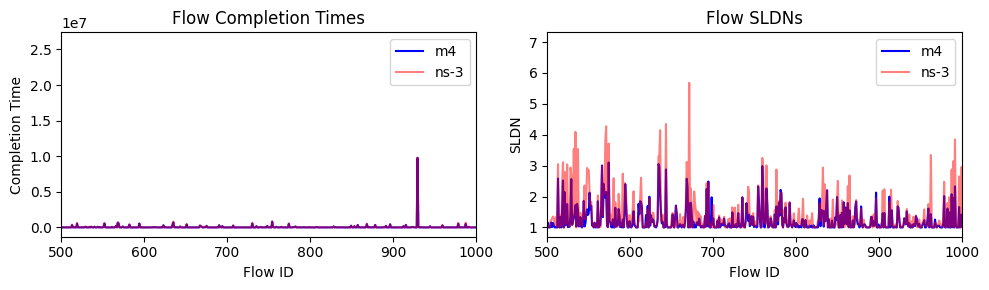

Mean relative error of SLDN per flow: 9.72%


NameError: name '_fontsize' is not defined

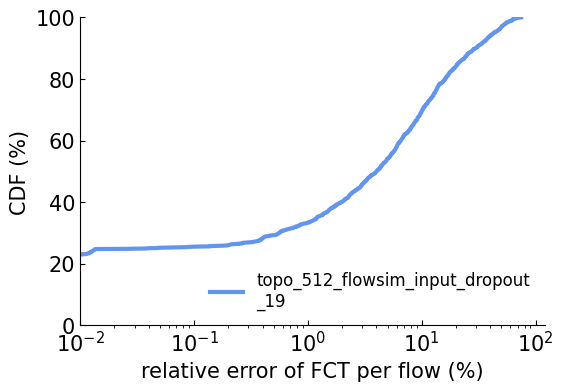

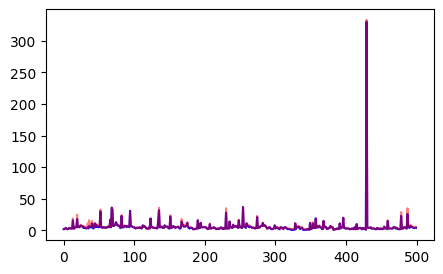

In [38]:
# Load the data from the .npz file
max_inflight_flows=0
scenario_idx=3
# model_instance = "link_batch"
# model_instance = "topo_512_remainsize"
model_instance = "topo_512_flowsim_input_dropout_19"
# model_instance = "topo_64"
# model_instance = "topo_512_remainsize_link"
# model_instance = "flowsim"
empirical_str = "_empirical"
# empirical_str=''
x_min=500
x_max=1000

fats=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/3/ns3/fat.npy')
fcts=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/3/ns3/fct_topology_flows_dctcp.npy')


data = np.load(f'./res/{model_instance}{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']

data_flowsim = np.load(f'./res/flowsim{empirical_str}.npz')
fct_flowsim = data_flowsim['fct']
sldn_flowsim = data_flowsim['sldn']

# Extract the data
predicted_completion_times = fct[scenario_idx, :, 0].flatten()
actual_completion_times = fct[scenario_idx, :, 1].flatten()
# predicted_sldns = sldn[scenario_idx, :, 0].flatten()-sldn_flowsim[scenario_idx, :1000, 0].flatten()
# actual_sldns = sldn[scenario_idx, :, 1].flatten()-sldn_flowsim[scenario_idx, :1000, 0].flatten()
predicted_sldns = sldn[scenario_idx, :, 0].flatten()
actual_sldns = sldn[scenario_idx, :, 1].flatten()

fid_rank = compute_active_flows(fats, actual_completion_times)
fid_rank_m4 = compute_active_flows(fats, predicted_completion_times)

predicted_sldns[predicted_sldns<1]=1
actual_sldns[actual_sldns<1]=1

print('Predicted Completion Times:', predicted_completion_times.shape)
# Plotting the completion times
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(predicted_completion_times, label='m4', color='b')
plt.plot(actual_completion_times, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID')
plt.ylabel('Completion Time')
plt.title('Flow Completion Times')
plt.legend()
plt.xlim(x_min, x_max)

# Plotting the SLDNs
plt.subplot(1, 2, 2)
plt.plot(predicted_sldns, label='m4', color='b')
plt.plot(actual_sldns, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID')
plt.ylabel('SLDN')
plt.title('Flow SLDNs')
plt.legend()
# plt.ylim(0, 6)
plt.xlim(x_min, x_max)
# Show the plots
plt.tight_layout()
plt.show()

res_error_sldn = np.abs(predicted_sldns - actual_sldns) / actual_sldns * 100
error_mean=np.mean(res_error_sldn)
print(f"Mean relative error of SLDN per flow: {error_mean:.2f}%")
fig_index=0
plot_cdf(
    [res_error_sldn],
    None,
    [f"{model_instance}"],
    x_label="relative error of FCT per flow (%)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=1,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1
fid_rank=fid_rank[x_min:x_max]
fid_rank_m4=fid_rank_m4[x_min:x_max]
plt.figure(figsize=(5, 3))
plt.plot(fid_rank_m4, label='m4', color='b')
plt.plot(fid_rank, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID',fontsize=_fontsize)
plt.ylabel('# of active flows',fontsize=_fontsize)
plt.xticks(fontsize=_fontsize-2)
plt.yticks(fontsize=_fontsize)
plt.legend(frameon=False,fontsize=_fontsize,loc='upper right')

Predicted Completion Times: (40000,)


(0.0, 20.0)

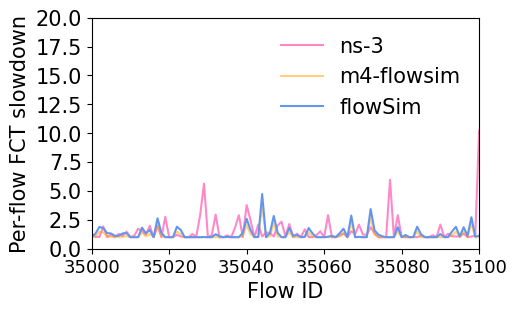

In [29]:
# Load the data from the .npz file
max_inflight_flows=0
scenario_idx=1
# model_instance = "link_batch"
# model_instance = "link_cplusplus"
model_instance = "topo_64_flowsim_input"
# model_instance = "flowsim"
empirical_str = "_empirical"
# empirical_str=''
_fontsize=15

data = np.load(f'./res/test_{model_instance}{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']
# Extract the data
predicted_completion_times = fct[scenario_idx, :, 0].flatten()
actual_completion_times = fct[scenario_idx, :, 1].flatten()
predicted_sldns = sldn[scenario_idx, :, 0].flatten()
predicted_sldns[predicted_sldns<1]=1
actual_sldns = sldn[scenario_idx, :, 1].flatten()
print('Predicted Completion Times:', predicted_completion_times.shape)

data = np.load(f'./res/test_flowsim{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']
# Extract the data
predicted_completion_times_flowsim = fct[scenario_idx, :, 0].flatten()
predicted_sldns_flowsim = sldn[scenario_idx, :, 0].flatten()
predicted_sldns_flowsim[predicted_sldns_flowsim<1]=1

# Plotting the completion times
plt.figure(figsize=(5, 3))
plt.plot(actual_sldns, label='ns-3', color=color_list[2],alpha=0.5)
plt.plot(predicted_sldns, label='m4-flowsim', color=color_list[1],alpha=0.5)
plt.plot(predicted_sldns_flowsim, label='flowSim', color=color_list[0])
plt.xlabel('Flow ID',fontsize=_fontsize)
plt.ylabel('Per-flow FCT slowdown',fontsize=_fontsize)
plt.xticks(fontsize=_fontsize-2)
plt.yticks(fontsize=_fontsize)
plt.legend(frameon=False,fontsize=_fontsize,loc='upper right')
plt.xlim(35000, 35100)
plt.ylim(0, 20)

# # Plotting the SLDNs
# plt.subplot(1, 2, 2)
# plt.plot(predicted_sldns, label='Predicted SLDN', color='b')
# plt.plot(actual_sldns, label='Actual SLDN', color='r',alpha=0.5)
# plt.xlabel('Flow ID')
# plt.ylabel('SLDN')
# plt.title('Flow SLDNs')
# plt.legend()
# # plt.ylim(0, 6)
# plt.xlim(20000, 21000)
# # Show the plots
# plt.tight_layout()
# plt.show()

fct: (82, 40000, 2), sldn: (82, 40000, 2)
Predicted Completion Times: (3280000,)
max sldn = 70.46686330495996, 69.51546478271484
mean error=16.2938576338757, 3.392343953565168
p99 error


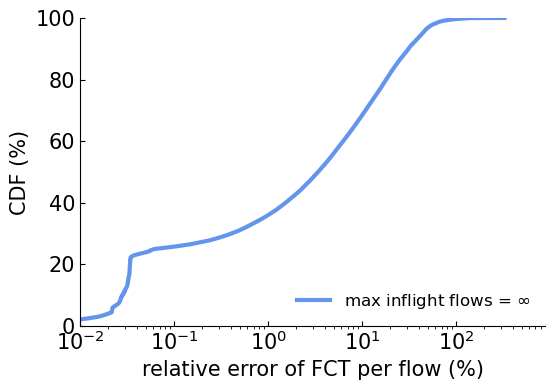

In [12]:
res_error_time=[]
res_error_sldn=[]
max_inflight_flows_list=[0]
flow_size_threshold='inf'
legend_list=[f'max inflight flows = {max_inflight_flows}' if max_inflight_flows!=0 else f'max inflight flows = $\infty$' for max_inflight_flows in max_inflight_flows_list]
for max_inflight_flows in max_inflight_flows_list:
    data = np.load(f'./res/inference_{model_instance}{empirical_str}.npz')
    fct = data['fct']
    sldn = data['sldn']
    print(f"fct: {fct.shape}, sldn: {sldn.shape}")
    
    # Extract the data
    predicted_completion_times = fct[:, :, 0].flatten()
    actual_completion_times = fct[:, :, 1].flatten()
    predicted_sldns = sldn[:, :, 0].flatten()
    actual_sldns = sldn[:, :, 1].flatten()
    print('Predicted Completion Times:', predicted_completion_times.shape)
    # calculate the relative error
    relative_error_time = np.abs(actual_completion_times - predicted_completion_times) / actual_completion_times *100
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    res_error_time.append(relative_error_time)
    res_error_sldn.append(relative_error_sldn)
    print(f"max sldn = {np.max(actual_sldns)}, {np.max(predicted_sldns)}")
    print(f"mean error={np.mean(relative_error_time)}, {np.median(relative_error_sldn)}")
    print(f"p99 error")

fig_index=0
plot_cdf(
    res_error_sldn,
    None,
    legend_list,
    x_label="relative error of FCT per flow (%)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=1,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1



flowsim-sldn: (68, 10000)
topo_512_flowsim_input_period23-sldn: (68, 10000)
error_list:[81.86786144366185, 76.3334773655706]
error_list:[20.037568161715416, 16.66487242714111]


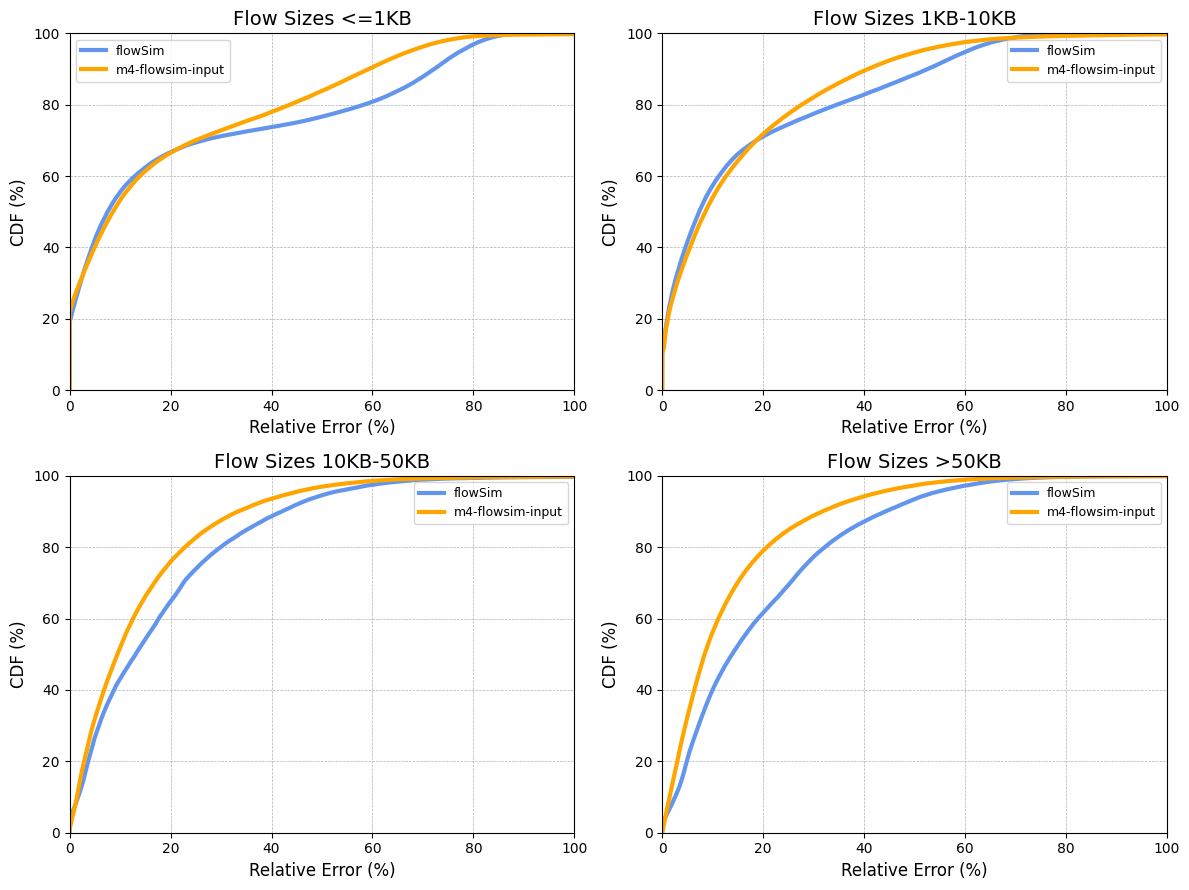

In [47]:
n_scenario=100
# empirical_str = ""
empirical_str = "_empirical"
# legend_list=['flowSim','m4','m4-flowsim-input','m4-flowsim-diff']
# model_instance_list=['flowsim','topo_512_remainsize','topo_512_flowsim_input_period23',"topo_512_flowsim_remainsize"]
legend_list=['flowSim','m4-flowsim-input']
model_instance_list=['flowsim','topo_512_flowsim_input_period23']
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
size_list=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/{i}/ns3/fid_topology_flows_dctcp.npy'):
        index_list_ori.append(i)
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/{i}/ns3/fsize.npy')
        size_list.append(sizes)
size_list=np.array(size_list)

index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    if spatial!="cluster_c_2_4":
        index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_size_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
    error_size_list.append(size_list[index_list])
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"error_list:{[np.percentile(x,99) for x in error_list]}")
print(f"error_list:{[np.mean(x) for x in error_list]}")


# Define flow size buckets
size_bins = [0, 1 * 1000, 10 * 1024, 50 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-10KB', '10KB-50KB', '>50KB']

# Initialize a dictionary to store errors per size bucket for each model instance
error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

# Process the data for each model instance
for mi in range(n_methods):
    legend = legend_list[mi]
    errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
    sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

    # Flatten the arrays
    errors_flat = errors.flatten()
    sizes_flat = sizes.flatten()

    # Assign flows to size buckets
    size_indices = np.digitize(sizes_flat, size_bins)

    # Collect errors for each size bucket
    for b in range(1, len(size_bins)):
        bin_mask = size_indices == b
        bin_errors = errors_flat[bin_mask]
        error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

# Plot the CDF of errors for each size bucket
plt.figure(figsize=(12, 9))
for idx, size_bin_label in enumerate(size_bin_labels):
    plt.subplot(2, 2, idx + 1)
    for mi, legend in enumerate(legend_list):
        bin_errors = error_bins[legend][size_bin_label]
        if len(bin_errors) > 0:
            # Sort the errors and compute the CDF
            sorted_errors = np.sort(bin_errors)
            yvals = np.arange(1, len(sorted_errors) + 1) / float(len(sorted_errors))
            plt.plot(sorted_errors, yvals * 100, label=legend, color=color_list[mi % len(color_list)], linewidth=3)
    plt.xlabel('Relative Error (%)', fontsize=12)
    plt.ylabel('CDF (%)', fontsize=12)
    plt.title(f'Flow Sizes {size_bin_label}', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=9)
    plt.xlim(left=0, right=100)
    plt.ylim([0, 100])
    plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()
plt.show()

flowsim-sldn: (68, 2000)
topo_512_flowsim_input_dropout_39-sldn: (68, 2000)
topo_512_flowsim_input_empirical_94-sldn: (68, 2000)
p99 error:[35.40366496442742, 21.289256441422463, 21.181514751645018]
mean error:[15.574792735909815, 8.44375731671126, 7.263871819884394]
median error:[13.704532378169448, 7.070499743332196, 5.752123874762793]


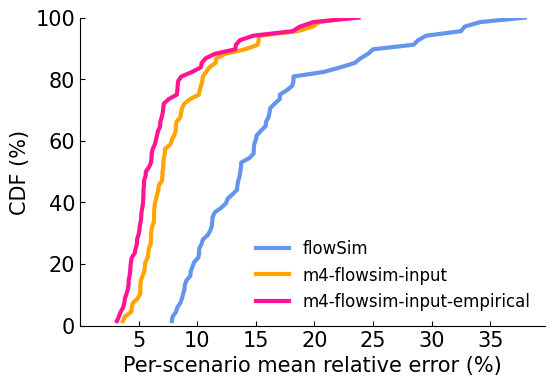

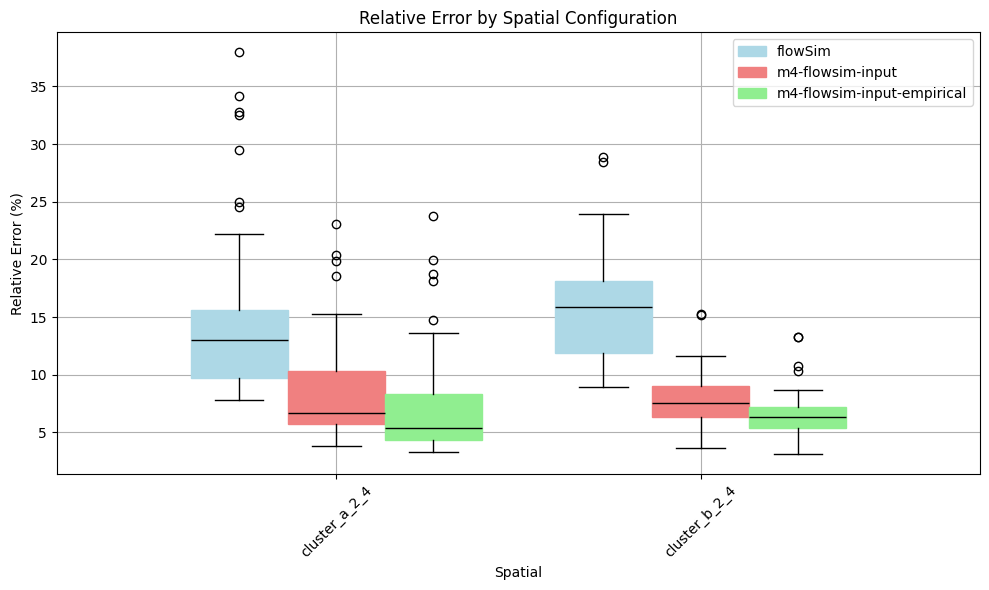

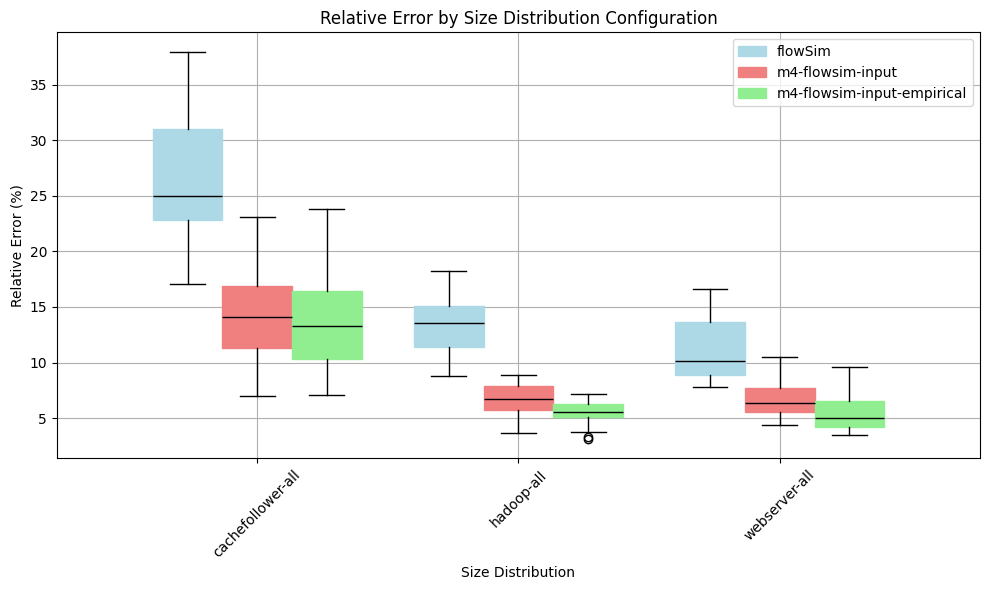

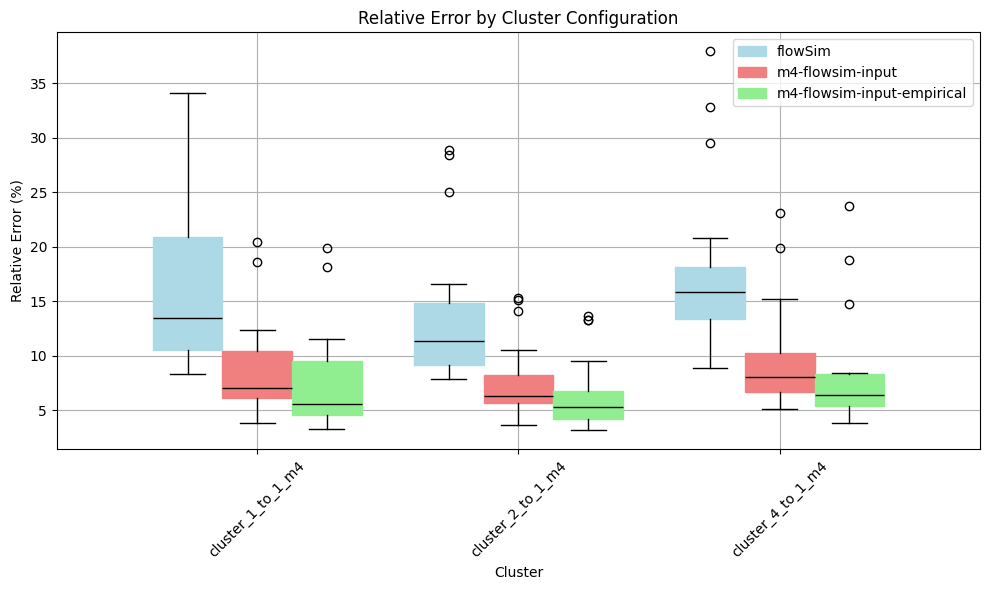

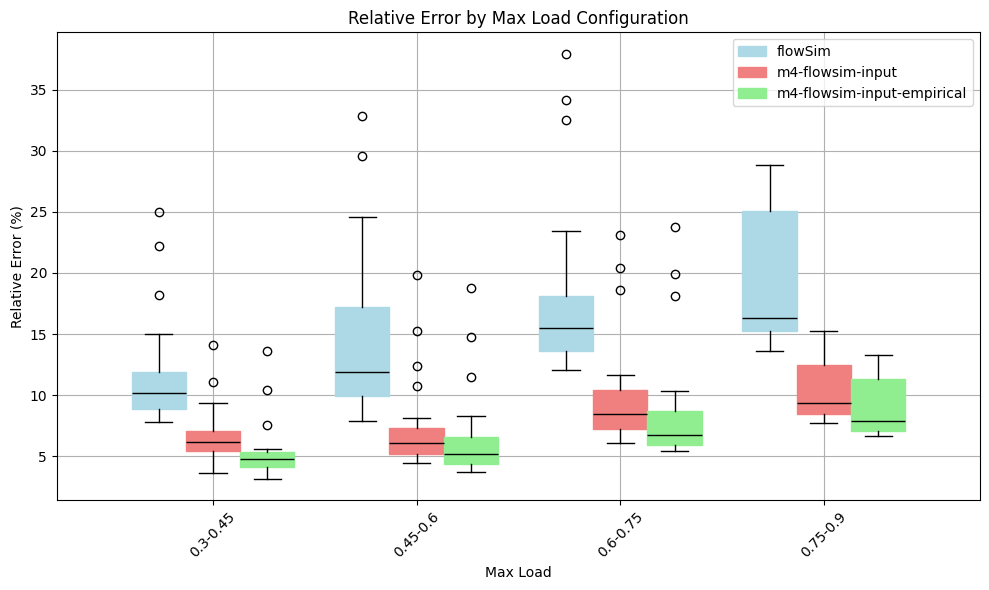

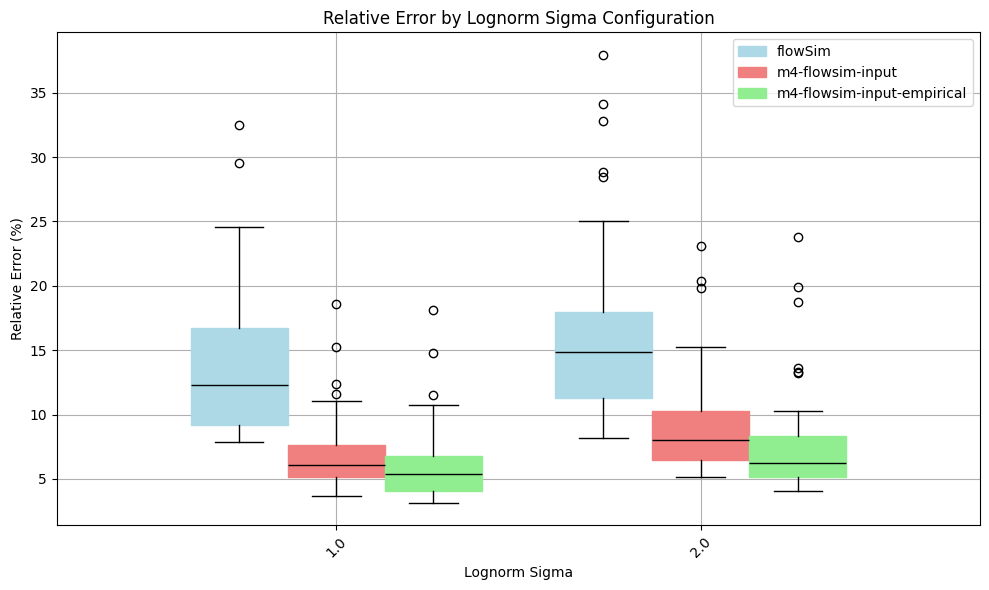

In [65]:
n_scenario=100
empirical_str = "_empirical"
# legend_list=['flowSim','m4','m4-flowsim-input','m4-flowsim-diff']
# model_instance_list=['flowsim','topo_512_remainsize','topo_512_flowsim_input_period23',"topo_512_flowsim_remainsize"]
# legend_list=['flowSim','m4-flowsim-input','m4-flowsim-input-empirical','m4-flowsim-inputfeat']
# model_instance_list=['flowsim','topo_512_flowsim_input_period23','topo_512_flowsim_input_empirical','topo_512_flowsim_inputfeat']
# legend_list=['flowSim','m4-flowsim-input-empirical','m4-flowsim-input-empirical-gnn','m4-flowsim-input-empirical-remainsize','m4-flowsim-input-empirical-gt','m4-flowsim-input-empirical-small']
# model_instance_list=['bflowsim','topo_512_flowsim_input_empirical','topo_512_flowsim_input_empirical_gnn','topo_512_flowsim_input_empirical_remainsize','topo_512_flowsim_input_empirical_gt','topo_512_flowsim_input_empirical_small']

# legend_list=['flowSim','m4-flowsim-input-empirical-14', 'm4-flowsim-input-empirical-24','m4-flowsim-input-empirical-34', 'm4-flowsim-input-empirical-44','m4-flowsim-input-empirical-94']
# model_instance_list=['flowsim','topo_512_flowsim_input_empirical_14','topo_512_flowsim_input_empirical_24','topo_512_flowsim_input_empirical_34', 'topo_512_flowsim_input_empirical_44','topo_512_flowsim_input_empirical_94']
legend_list=['flowSim','m4-flowsim-input','m4-flowsim-input-empirical']
model_instance_list=['flowsim','topo_512_flowsim_input_dropout_39', 'topo_512_flowsim_input_empirical_94']
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/{i}/ns3/fid_topology_flows_dctcp.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    if spatial!="cluster_c_2_4":
        index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)

# Define bins and labels (corrected)
bins = [0.3, 0.45, 0.6, 0.75, 0.9]
labels = ['0.3-0.45', '0.45-0.6', '0.6-0.75', '0.75-0.9']

# Discretize max_load_values
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1

# Assign labels to the discretized values
max_load_labels = [labels[i] for i in max_load_bins]

# Update config_list with discretized max_load labels
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]

# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim-sldn: (100, 10000)
topo_512_flowsim_input_dropout_29-sldn: (100, 10000)
btopo_512_flowsim_input_empirical_v1-sldn: (100, 10000)
p99 error:[24.76066360903677, 20.191506154209158, 14.88328208266369]
mean error:[11.983808224096288, 8.970486813740115, 7.649586467865894]
median error:[11.454926293749722, 8.588080600263526, 6.899565936025395]


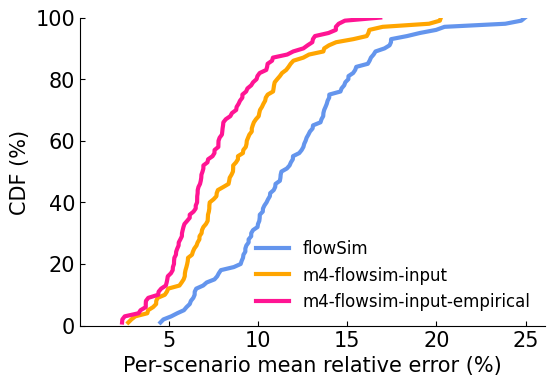

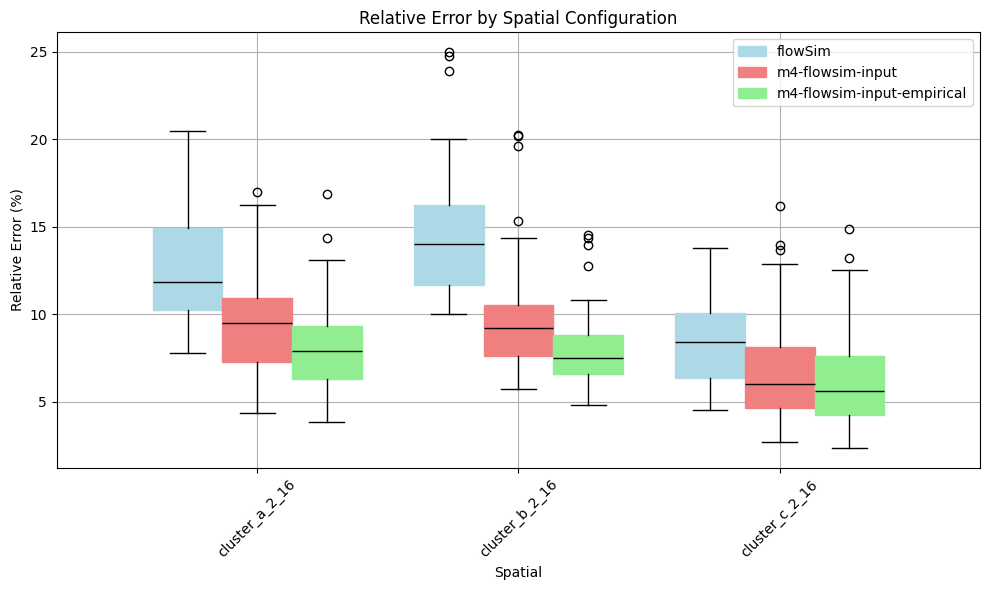

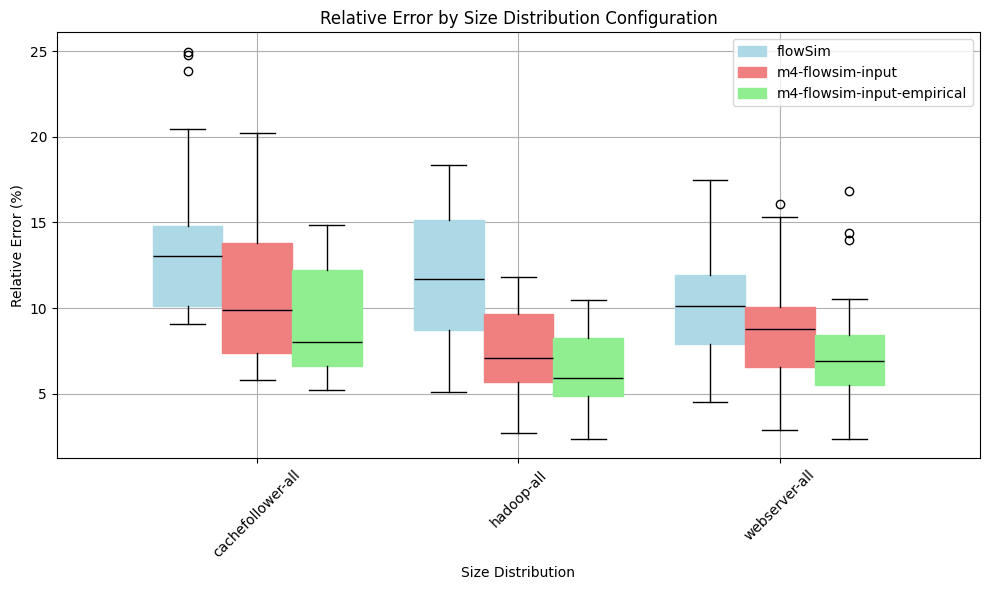

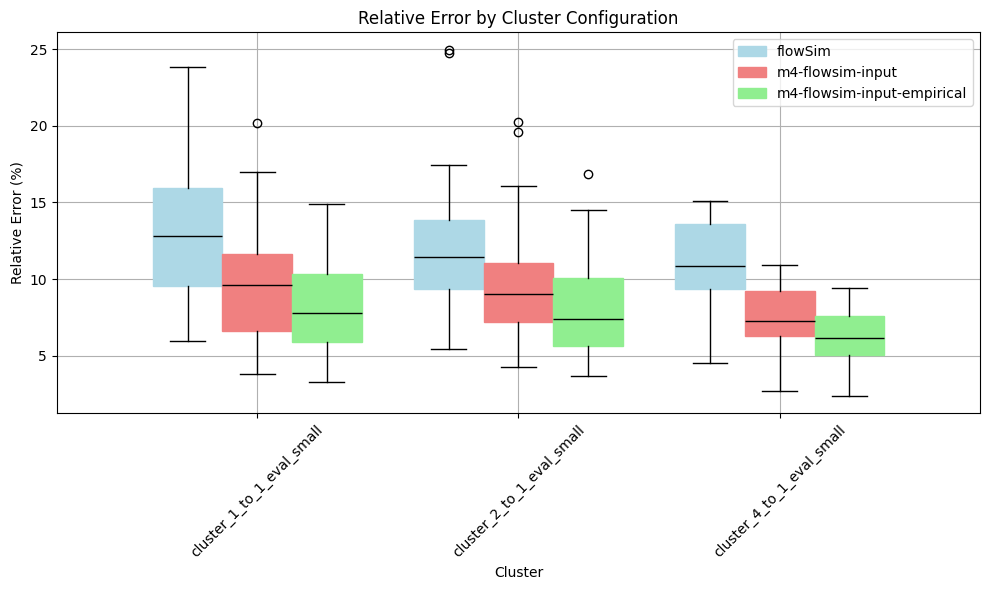

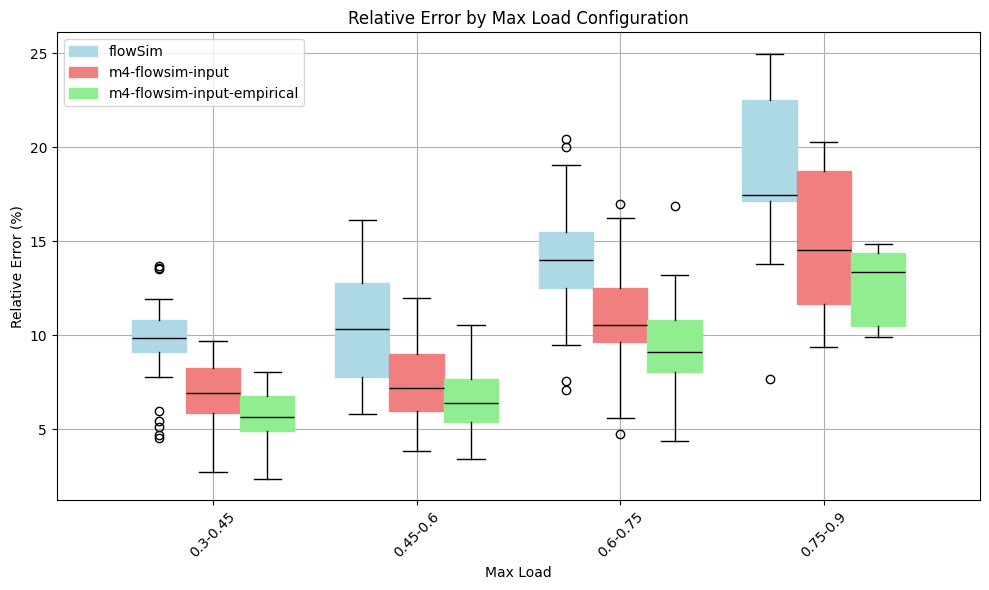

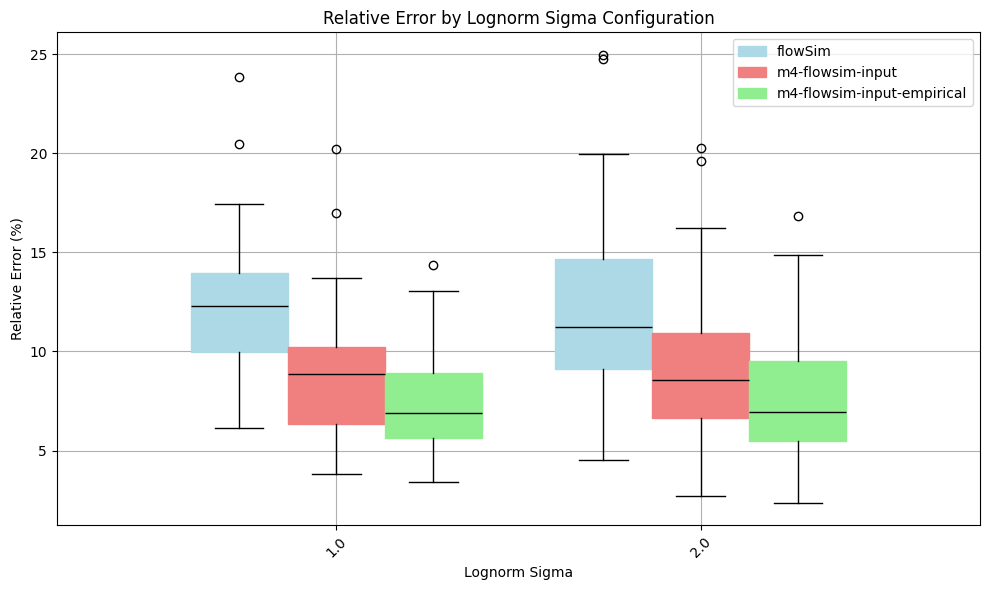

In [29]:
n_scenario=100
empirical_str = "_eval_small"
# legend_list=['flowSim','m4-flowsim-input','m4-flowsim-input-empirical-v1','m4-flowsim-input-empirical']
# model_instance_list=['flowsim','btopo_512_flowsim_input','btopo_512_flowsim_input_empirical_v1','btopo_512_flowsim_input_empirical']
# legend_list=['flowSim','m4-flowsim-input-empirical-14', 'm4-flowsim-input-empirical-24','m4-flowsim-input-empirical-34', 'm4-flowsim-input-empirical-44','m4-flowsim-input-empirical-54','m4-flowsim-input-empirical-64','m4-flowsim-input-empirical-74','m4-flowsim-input-empirical-84','m4-flowsim-input-empirical-94', 'm4-flowsim-input-empirical-104','m4-flowsim-input-empirical-114']
# model_instance_list=['flowsim','topo_512_flowsim_input_empirical_14','topo_512_flowsim_input_empirical_24','topo_512_flowsim_input_empirical_34', 'topo_512_flowsim_input_empirical_44','topo_512_flowsim_input_empirical_54','topo_512_flowsim_input_empirical_64','topo_512_flowsim_input_empirical_74','topo_512_flowsim_input_empirical_84','topo_512_flowsim_input_empirical_94', 'topo_512_flowsim_input_empirical_104','topo_512_flowsim_input_empirical_114']
legend_list=['flowSim', 'm4-flowsim-input','m4-flowsim-input-empirical']
model_instance_list=['flowsim', 'topo_512_flowsim_input_dropout_29','btopo_512_flowsim_input_empirical_v1']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp_eval.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data{empirical_str}/{i}/ns3/fid_topology_flows_dctcp.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    # if spatial!="cluster_c_2_16":
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)

# Define bins and labels (corrected)
bins = [0.3, 0.45, 0.6, 0.75, 0.9]
labels = ['0.3-0.45', '0.45-0.6', '0.6-0.75', '0.75-0.9']

# Discretize max_load_values
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1

# Assign labels to the discretized values
max_load_labels = [labels[i] for i in max_load_bins]

# Update config_list with discretized max_load labels
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]

# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim-sldn: (100, 30000)
topo_512_flowsim_input_dropout_19-sldn: (100, 30000)
topo_13-sldn: (100, 30000)
topo_remainsize_small_10_8-sldn: (100, 30000)
topo_remainsize_small_10_7-sldn: (100, 30000)
topo_remainsize_small_10_6-sldn: (100, 30000)
p99 error:[41.27689255218695, 29.263232535046164, 27.626207100293538, 27.173124618172512, 29.53376245285153, 27.804065450291905]
mean error:[16.58962357052526, 11.084309221921544, 11.272201502205519, 11.623372871624378, 13.18475256625515, 11.874978442247938]
median error:[13.887536295190653, 9.457109428277466, 9.700348412579118, 10.380158962803645, 12.056694175262043, 10.64746926473213]


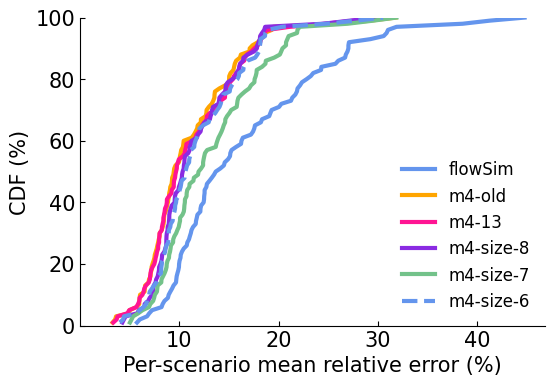

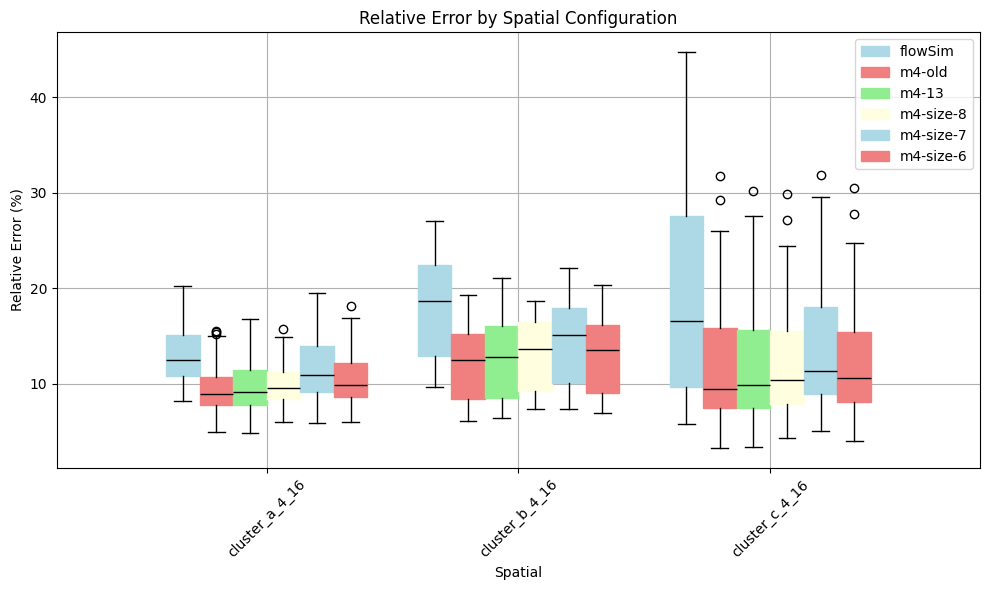

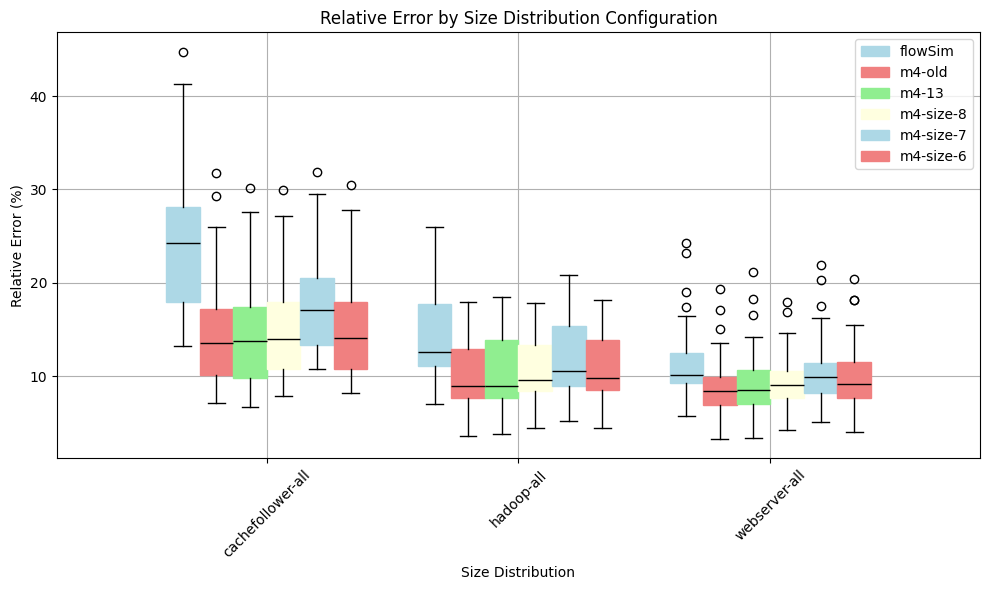

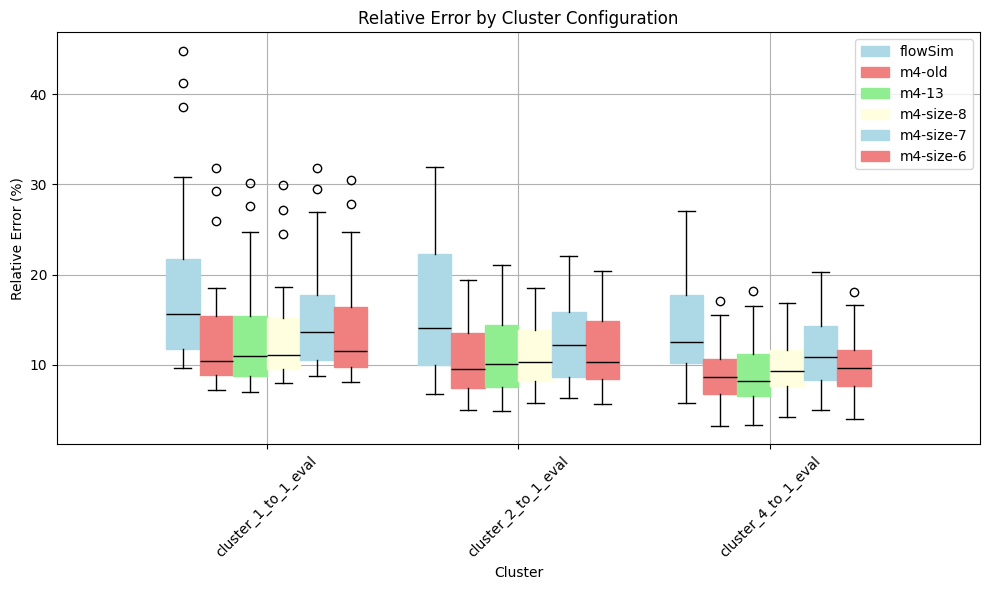

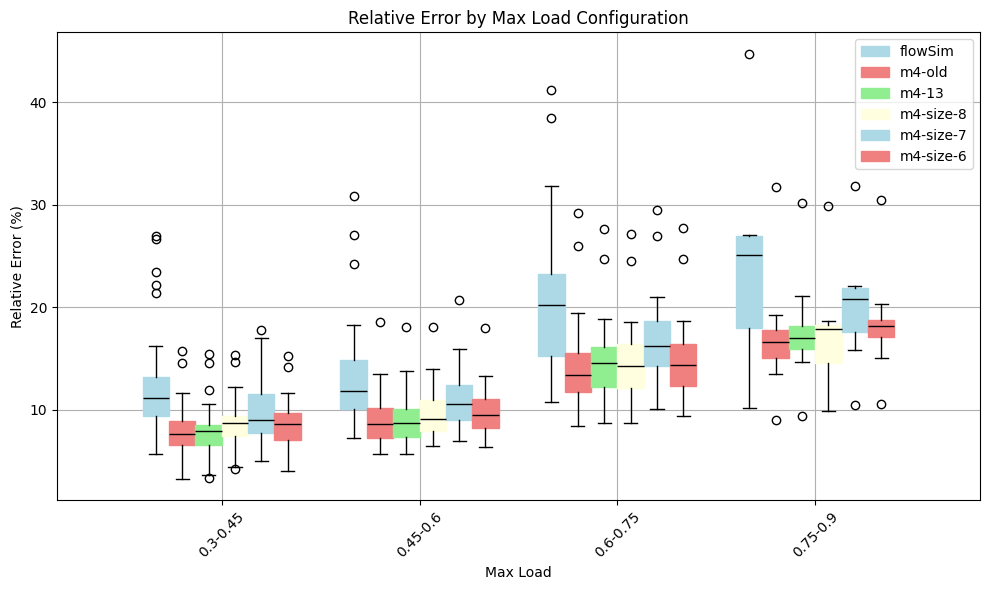

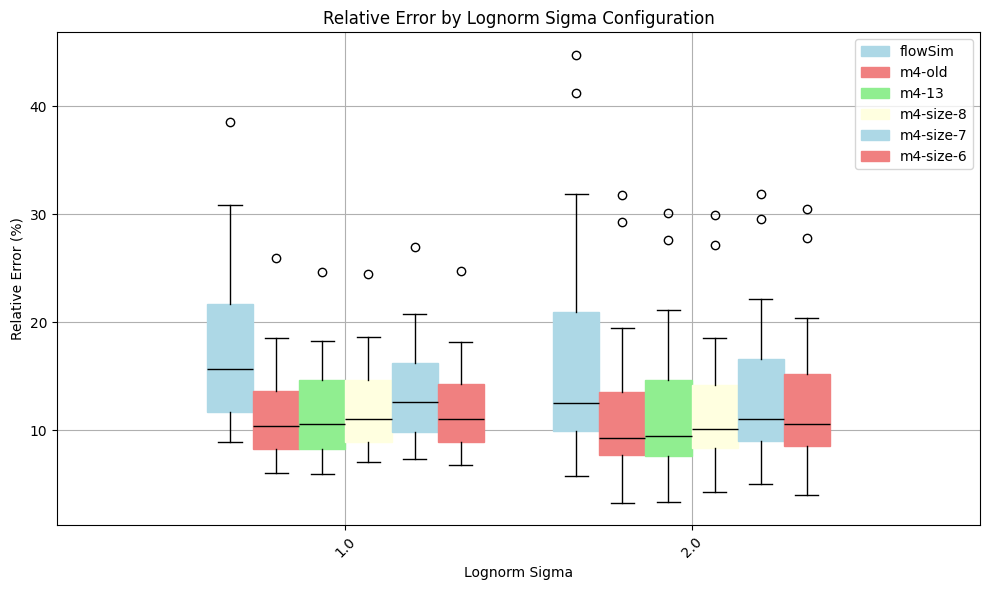

In [9]:
n_scenario=100
empirical_str = "_eval_sweep"
# legend_list=['flowSim','m4-old','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8']
# model_instance_list=['flowsim','topo_512_flowsim_input_dropout_19','topo_15','topo_14','topo_13','topo_12','topo_11','topo_10','topo_9','topo_8']

legend_list=['flowSim','m4-old','m4-13','m4-size-8','m4-size-7','m4-size-6']
model_instance_list=['flowsim','topo_512_flowsim_input_dropout_19','topo_13','topo_remainsize_small_10_8','topo_remainsize_small_10_7','topo_remainsize_small_10_6']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp_eval.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    # if spatial!="cluster_c_4_16":
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)

# Define bins and labels (corrected)
bins = [0.3, 0.45, 0.6, 0.75, 0.9]
labels = ['0.3-0.45', '0.45-0.6', '0.6-0.75', '0.75-0.9']

# Discretize max_load_values
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1

# Assign labels to the discretized values
max_load_labels = [labels[i] for i in max_load_bins]

# Update config_list with discretized max_load labels
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]

# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim-sldn: (100, 30000)
topo_remainsize_small_12-sldn: (100, 30000)
topo_remainsize_large_15-sldn: (100, 30000)
topo_remainsize_21-sldn: (100, 30000)
p99 error:[29.125316831172658, 26.783919219003735, 29.046653700036604, 27.72252935180036]
mean error:[15.503885951453661, 13.604152440426432, 14.410615631125513, 14.590239561493972]
median error:[13.260905791888103, 12.939162909647496, 13.424583293531025, 13.939818771591002]


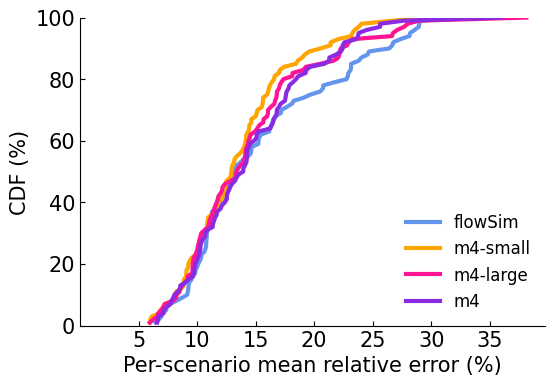

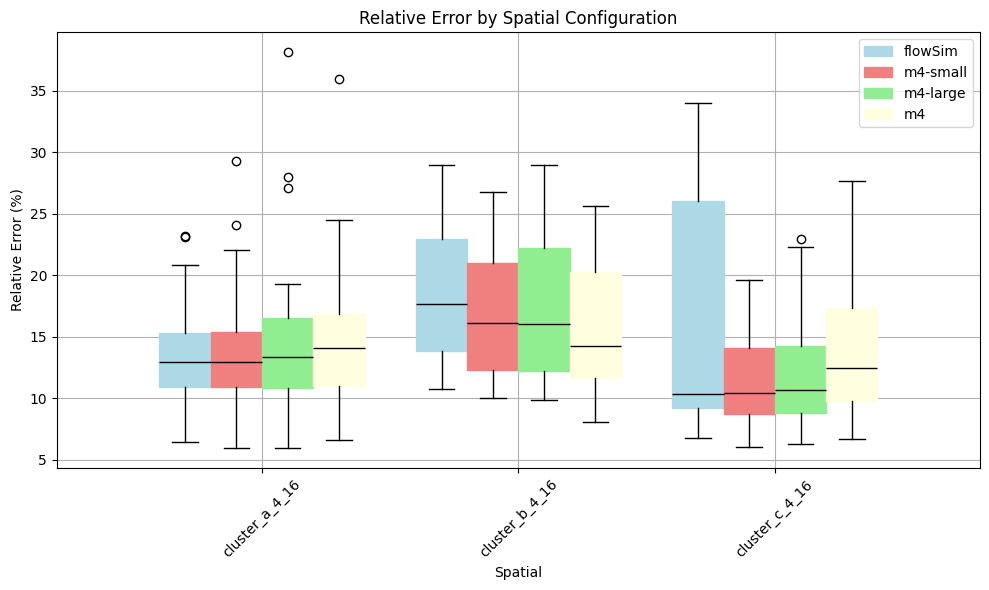

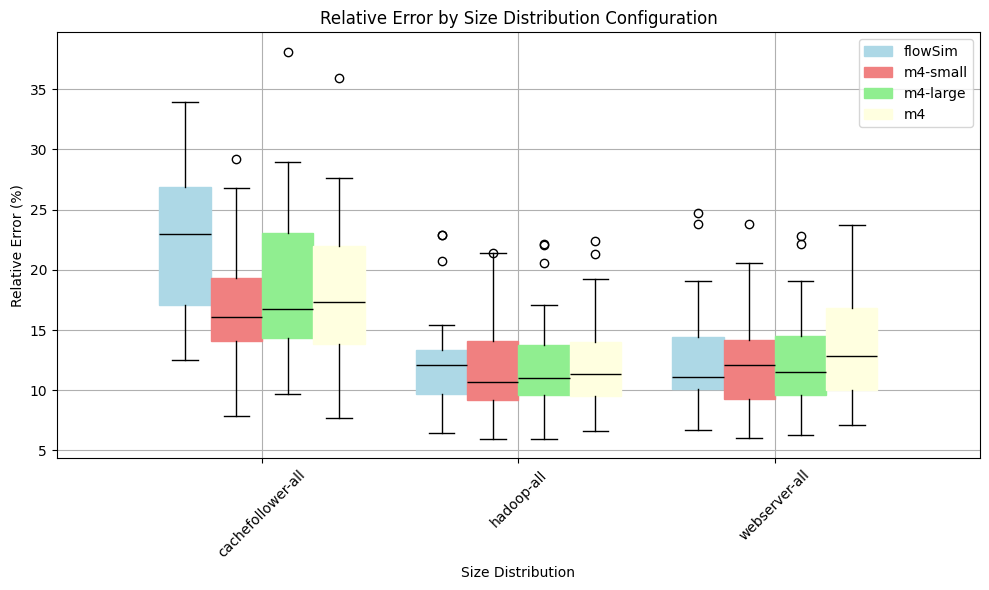

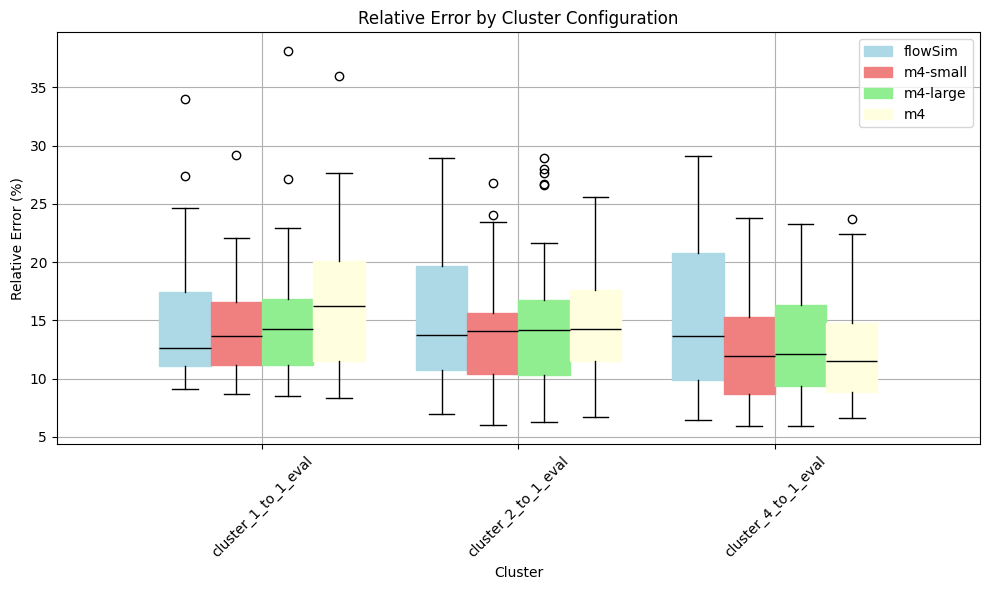

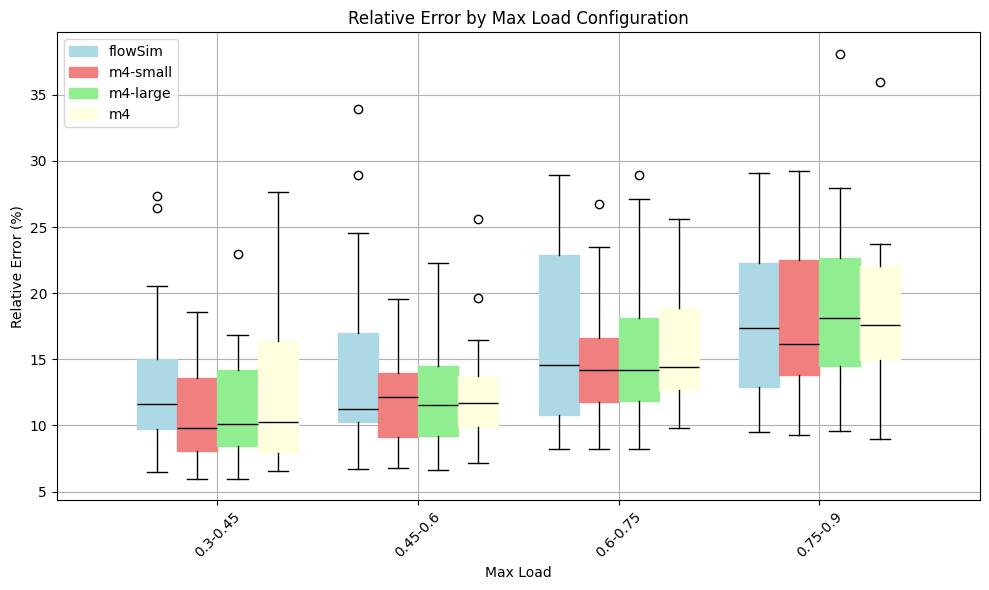

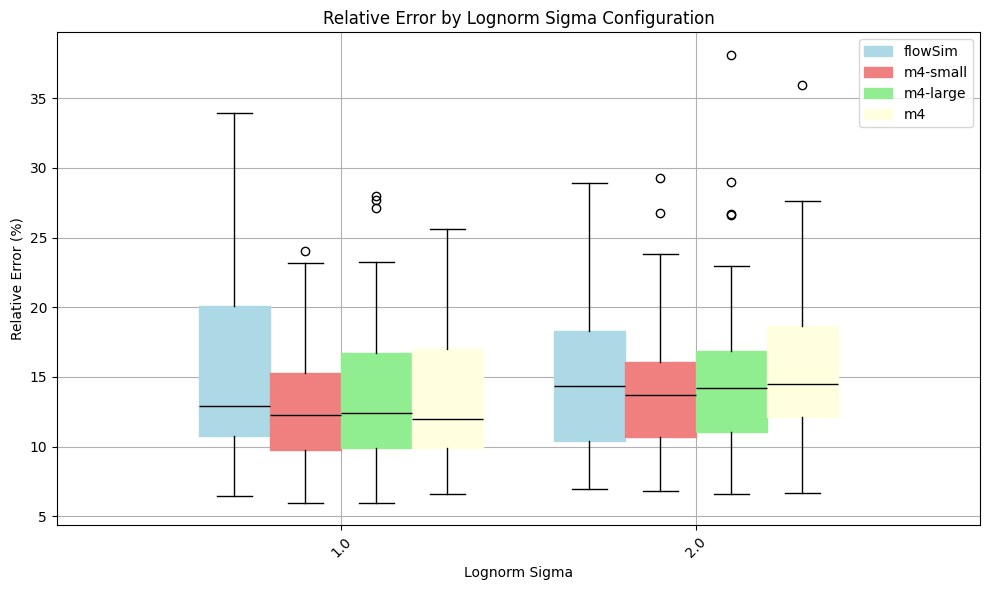

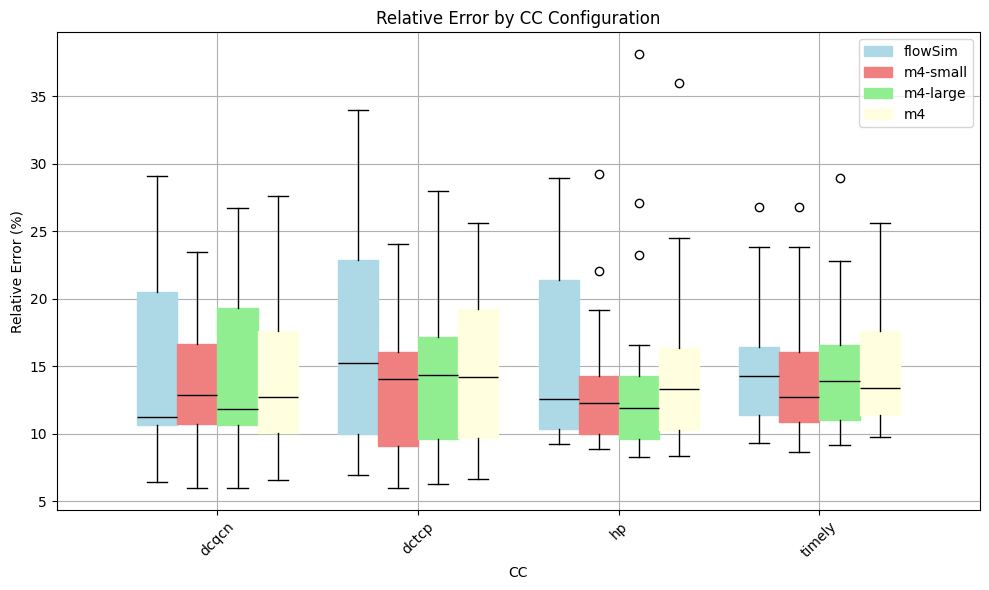

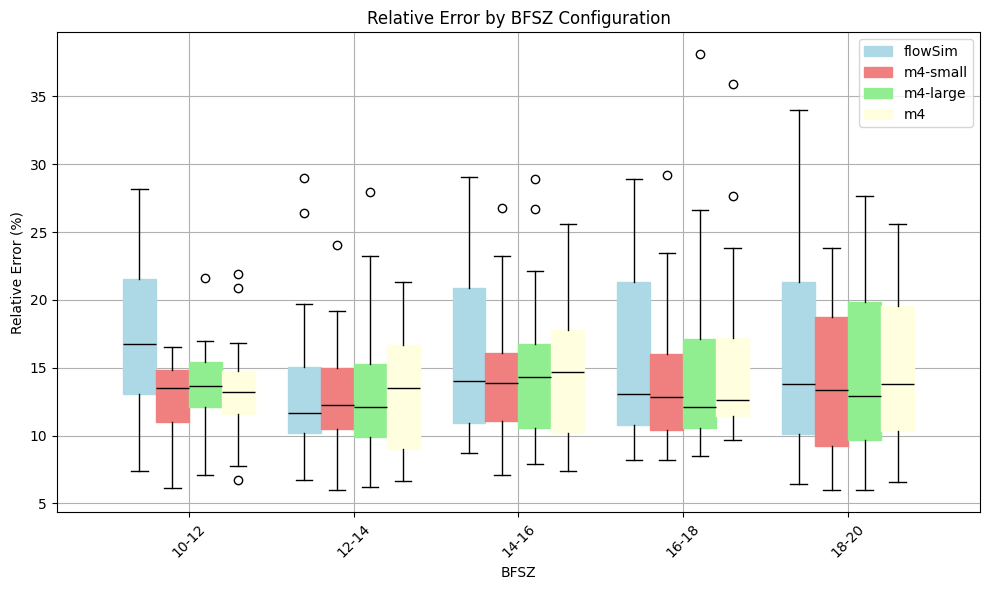

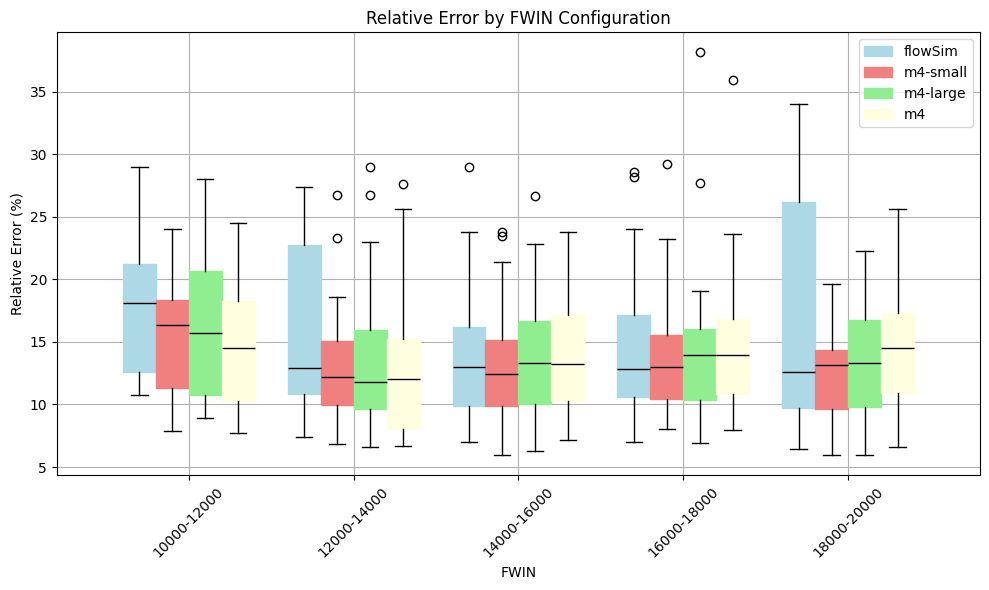

In [54]:
n_scenario=100
empirical_str = "eval_test"
# legend_list=['flowSim','m4-40','m4-35','m4-30','m4-25','m4-20']
# model_instance_list=['flowsim','topo_40','topo_35','topo_30','topo_25','topo_20']
# legend_list=['flowSim','m4-30','m4-20','m4-19','m4-18','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']
# model_instance_list=['flowsim','topo_30','topo_20','topo_19','topo_18','topo_17','topo_16','topo_15','topo_14','topo_13','topo_12','topo_11','topo_10','topo_9','topo_8','topo_7','topo_6','topo_5']
# legend_list=['flowSim','m4-30','m4-25','m4-20','m4-19','m4-18','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6']
# model_instance_list=['flowsim','topo_remainsize_small_30','topo_remainsize_small_25','topo_remainsize_small_20','topo_remainsize_small_19','topo_remainsize_small_18','topo_remainsize_small_17','topo_remainsize_small_16','topo_remainsize_small_15','topo_remainsize_small_14','topo_remainsize_small_13','topo_remainsize_small_12','topo_remainsize_small_11','topo_remainsize_small_10','topo_remainsize_small_9','topo_remainsize_small_8','topo_remainsize_small_7','topo_remainsize_small_6']
# legend_list=['flowSim','m4-20','m4-19','m4-18','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6']
# model_instance_list=['flowsim','topo_remainsize_20','topo_remainsize_19','topo_remainsize_18','topo_remainsize_17','topo_remainsize_16','topo_remainsize_15','topo_remainsize_14','topo_remainsize_13','topo_remainsize_12','topo_remainsize_11','topo_remainsize_10','topo_remainsize_9','topo_remainsize_8','topo_remainsize_7','topo_remainsize_6']
# legend_list=['flowSim','m4-24','m4-21','m4-18','m4-15','m4-12','m4-9']
# model_instance_list=['flowsim','topo_remainsize_24','topo_remainsize_21','topo_remainsize_18','topo_remainsize_15','topo_remainsize_12','topo_remainsize_9']
# legend_list=['flowSim','m4-small','m4-large','m4']
# model_instance_list=['flowsim','topo_remainsize_small_12','topo_remainsize_large_15','topo_remainsize_21']
legend_list=['flowSim','m4-small','m4-large','m4']
model_instance_list=['flowsim','topo_remainsize_small_12','topo_remainsize_large_15','topo_remainsize_21']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.45, 0.6, 0.75, 0.9]
labels = ['0.3-0.45', '0.45-0.6', '0.6-0.75', '0.75-0.9']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
flowsim-sldn: (10, 30000)
topo_remainsize_large_data_7-sldn: (10, 30000)
topo_featrate_7-sldn: (10, 30000)
topo_dropout_10-sldn: (10, 30000)
topo_dropout_9-sldn: (10, 30000)
topo_dropout_8-sldn: (10, 30000)
topo_dropout_7-sldn: (10, 30000)
topo_dropout_6-sldn: (10, 30000)
p99 error:[33.22233768028219, 20.11230491136666, 19.60177616061744, 22.598005283143628, 22.17633648564856, 20.823744475642187, 20.5233504878941, 20.46074139985164]
mean error:[18.541355880807682, 13.81301714933409, 13.796166730793365, 15.01579209163928, 14.841079766335545, 14.262262107038671, 14.427054043307084, 14.061666033237739]
median error:[17.19638173296968, 12.425792107059753, 12.926118442442379, 13.340047605353655, 13.260744899072407, 12.354634248517193, 12.931101414135394, 13.026195896228705]


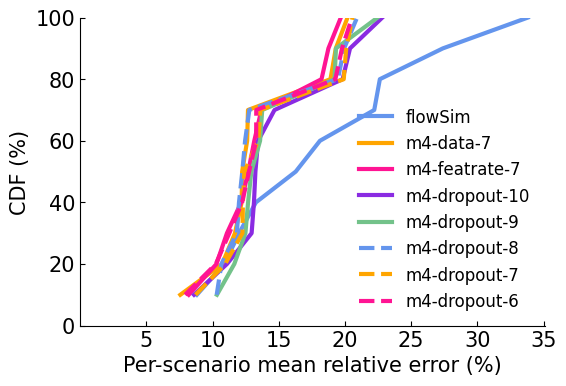

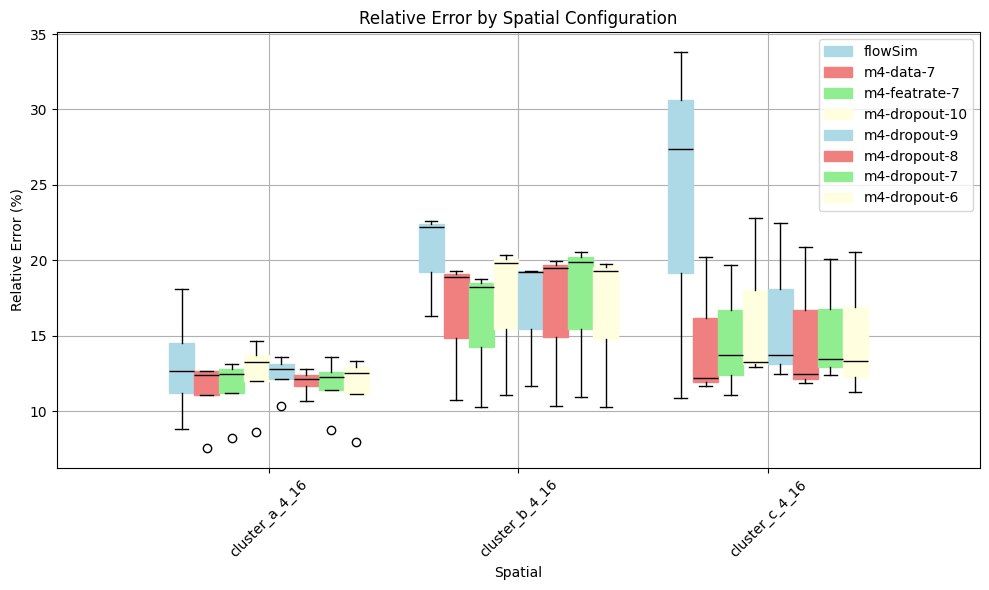

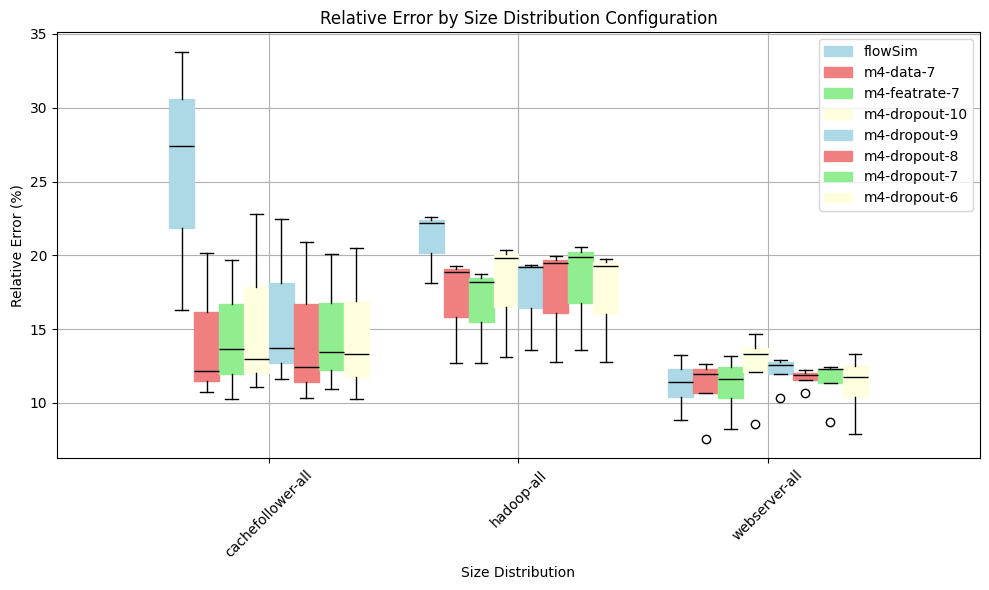

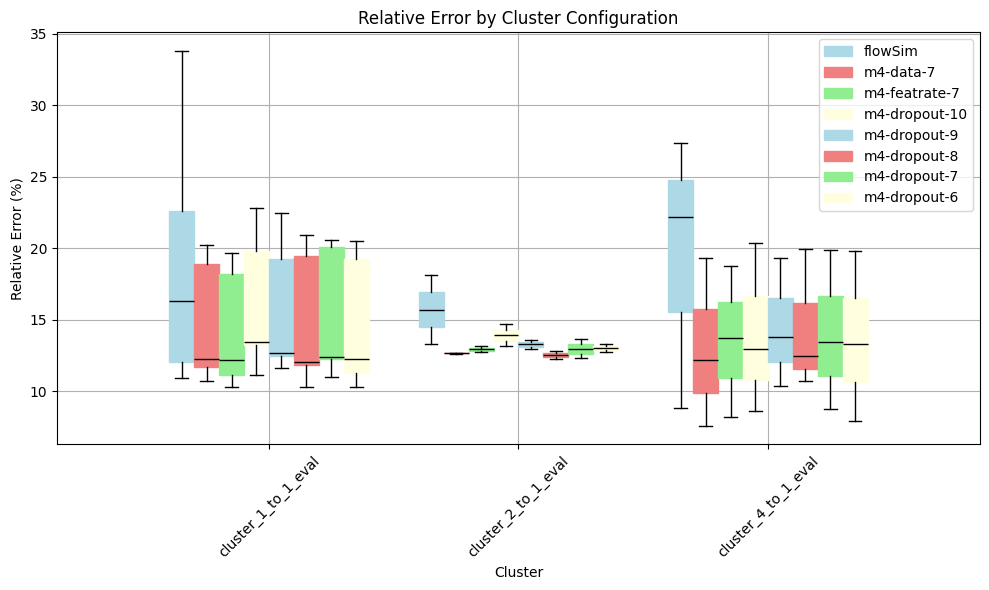

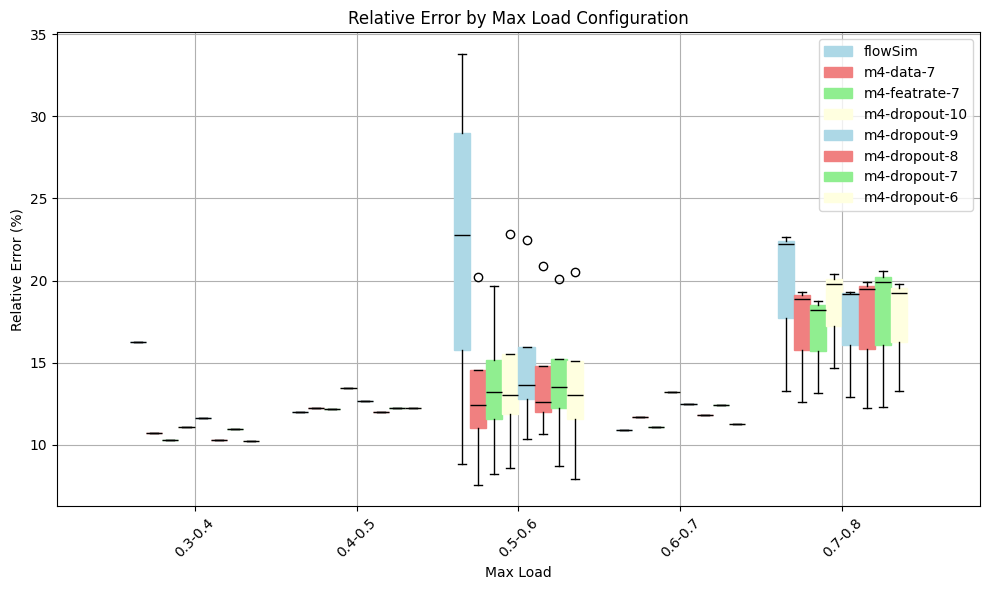

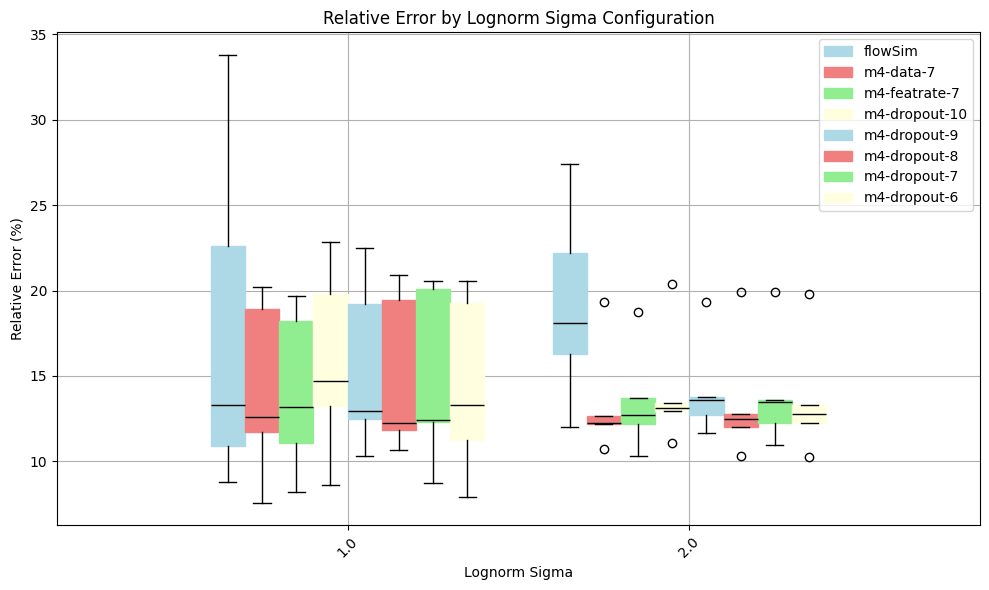

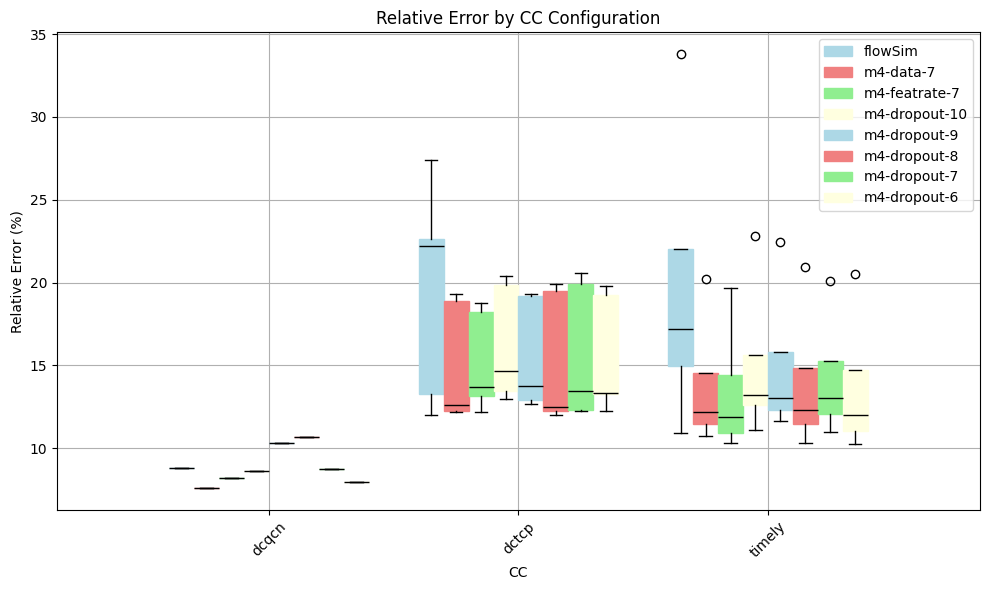

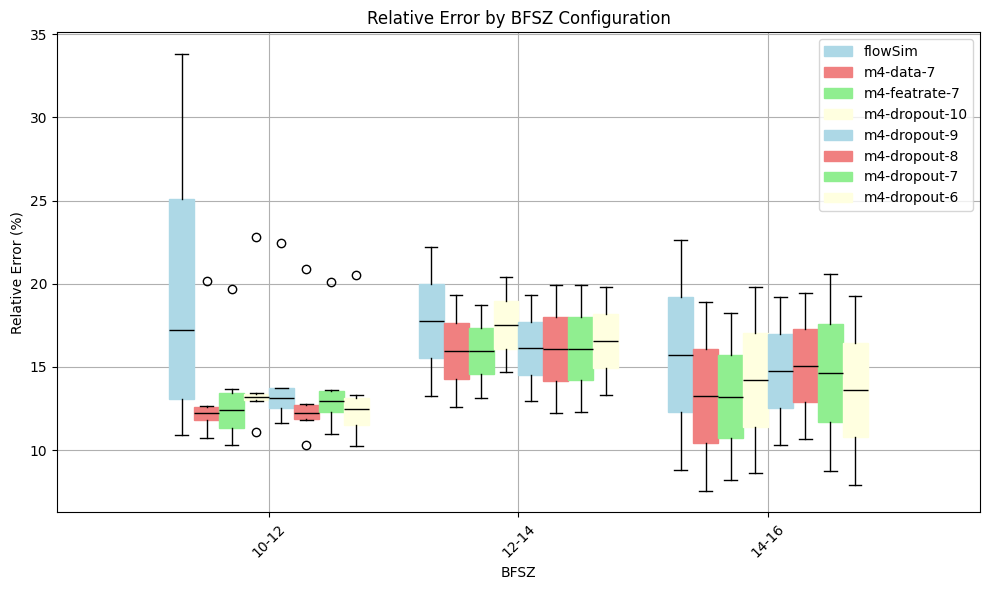

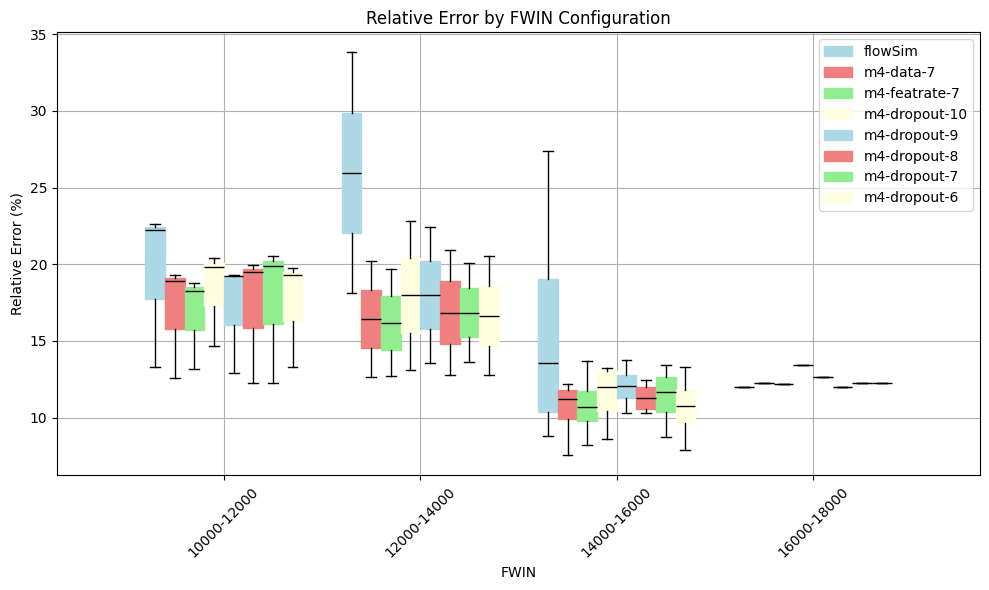

In [67]:
n_scenario=10
empirical_str = "eval_test_new"
# 13
# legend_list=['flowSim','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11']
# model_instance_list=['flowsim','topo_remainsize_17','topo_remainsize_16','topo_remainsize_15','topo_remainsize_14','topo_remainsize_13','topo_remainsize_12','topo_remainsize_11']
# 10
# legend_list=['flowSim','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9']
# model_instance_list=['flowsim','topo_remainsize_large_17','topo_remainsize_large_16','topo_remainsize_large_15','topo_remainsize_large_14','topo_remainsize_large_13','topo_remainsize_large_12','topo_remainsize_large_11','topo_remainsize_large_10','topo_remainsize_large_9']
# 7
# legend_list=['flowSim','m4-10','m4-9','m4-8','m4-7','m4-6']
# model_instance_list=['flowsim','topo_remainsize_large_data_10','topo_remainsize_large_data_9','topo_remainsize_large_data_8','topo_remainsize_large_data_7','topo_remainsize_large_data_6']

# legend_list=['flowSim','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5','m4-4','m4-3','m4-2']
# model_instance_list=['flowsim','topo_11','topo_10','topo_9','topo_8','topo_7','topo_6','topo_5','topo_4','topo_3','topo_2']
# legend_list=['flowSim','m4-8','m4-7','m4-6','m4-5','m4-4']
# model_instance_list=['flowsim','topo_feat_8','topo_feat_7','topo_feat_6','topo_feat_5','topo_feat_4']
# legend_list=['flowSim','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']
# model_instance_list=['flowsim','topo_featrate_10','topo_featrate_9','topo_featrate_8','topo_featrate_7','topo_featrate_6','topo_featrate_5']
legend_list=['flowSim','m4-data-7','m4-featrate-7','m4-dropout-10','m4-dropout-9','m4-dropout-8','m4-dropout-7','m4-dropout-6']
model_instance_list=['flowsim','topo_remainsize_large_data_7','topo_featrate_7','topo_dropout_10','topo_dropout_9','topo_dropout_8','topo_dropout_7','topo_dropout_6']

# legend_list=['flowSim','m4-data']
# model_instance_list=['flowsim','topo_remainsize_large_data_7']

                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    # if size_dist!='webserver-all':
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim-sldn: (79, 60000)
topo_featrate_7-sldn: (79, 60000)
topo_remainsize_large_data_7-sldn: (79, 60000)
p99 error:[46.860948626701465, 30.508477515470172, 34.51706071717531]
mean error:[17.73937799833426, 11.674888138024574, 11.984042076011427]
median error:[15.829607914797883, 10.61715677096737, 10.764528460829533]
p99 error:[23.108497453037526, 11.33300813783294, 9.967720913682598]


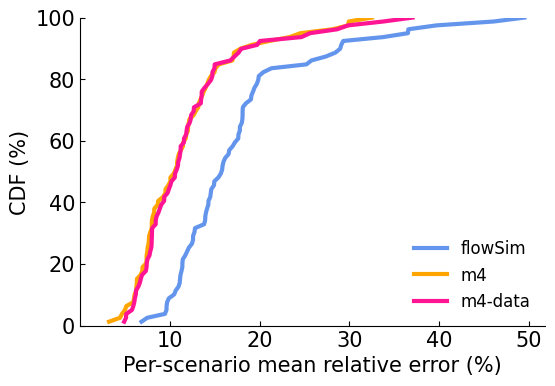

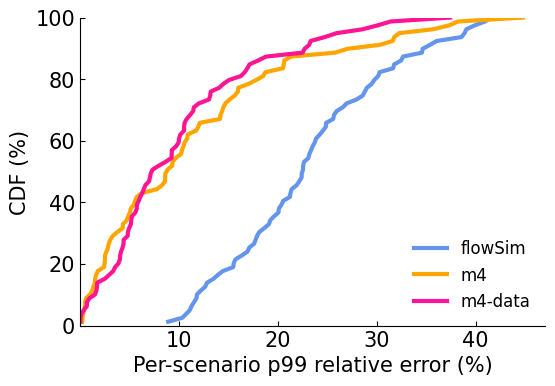

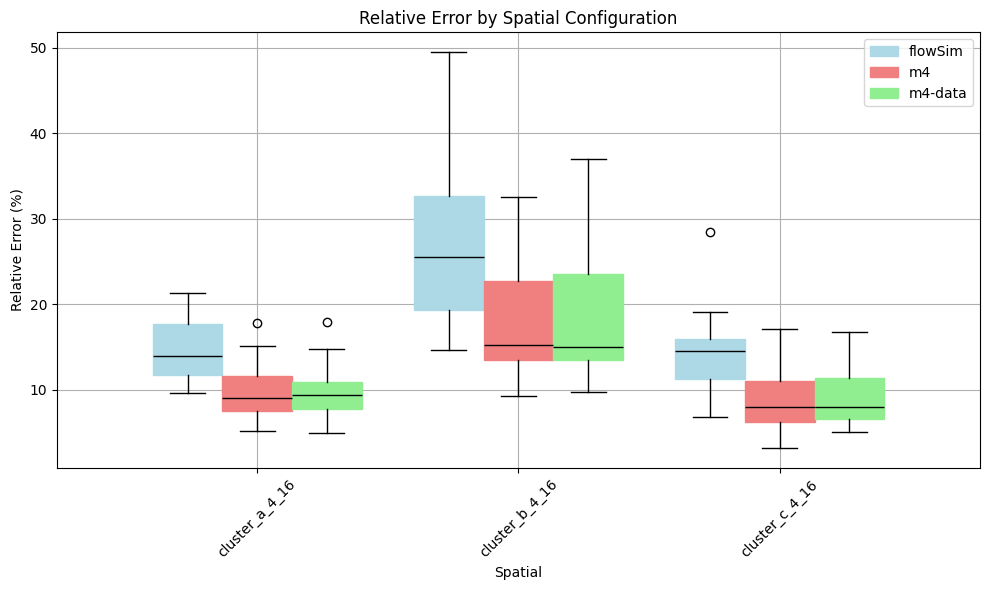

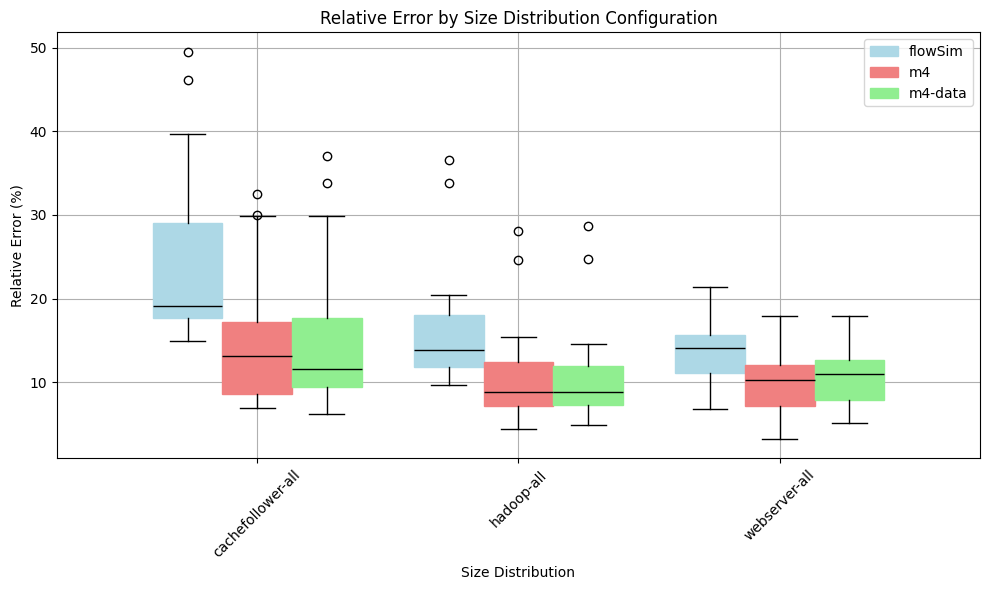

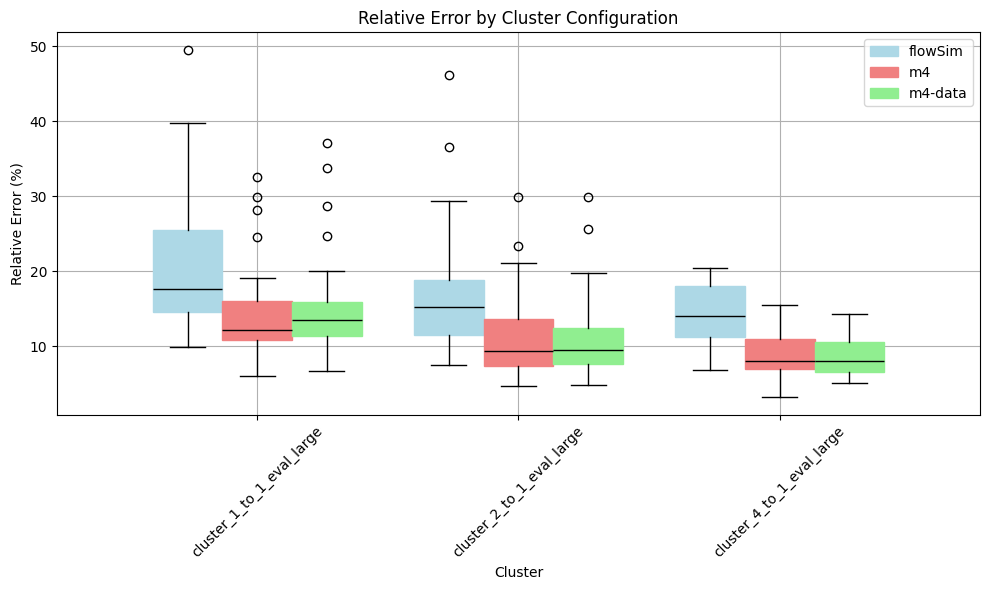

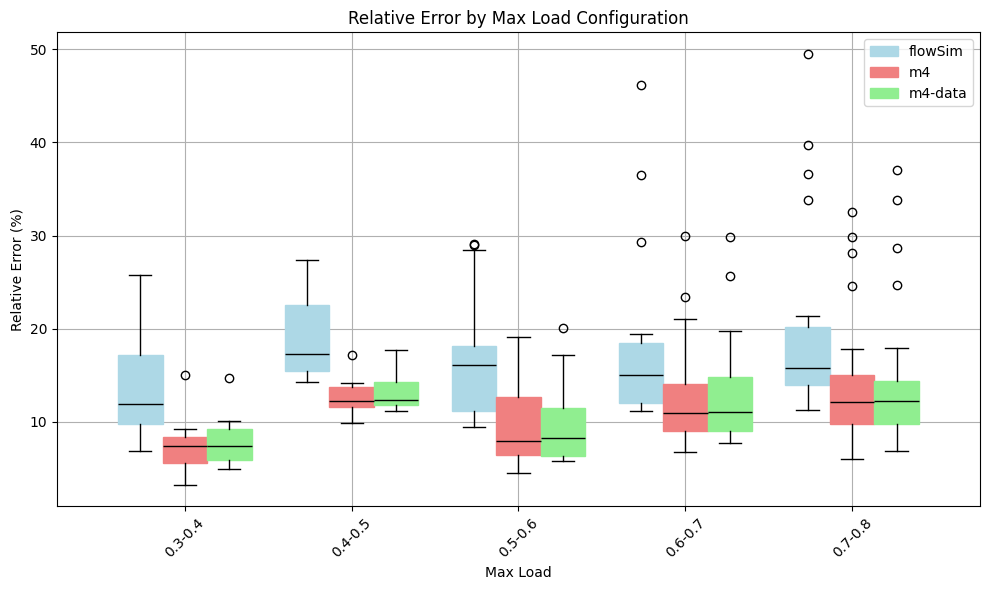

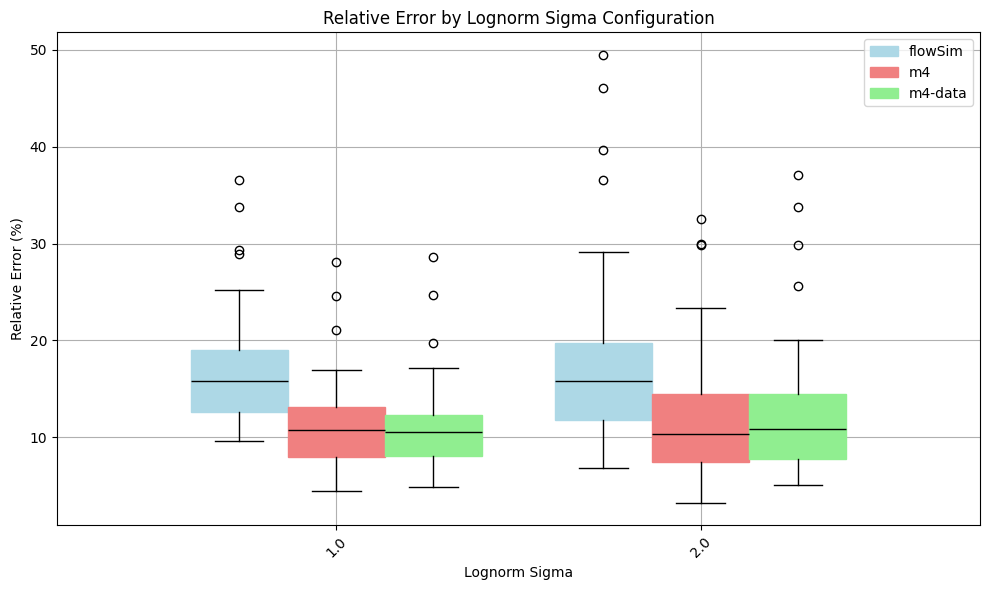

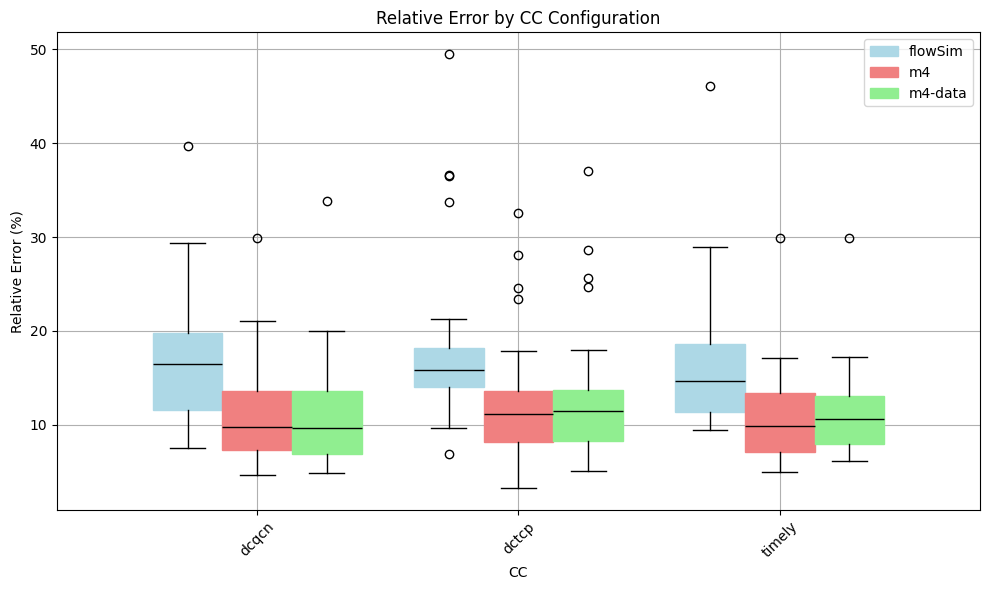

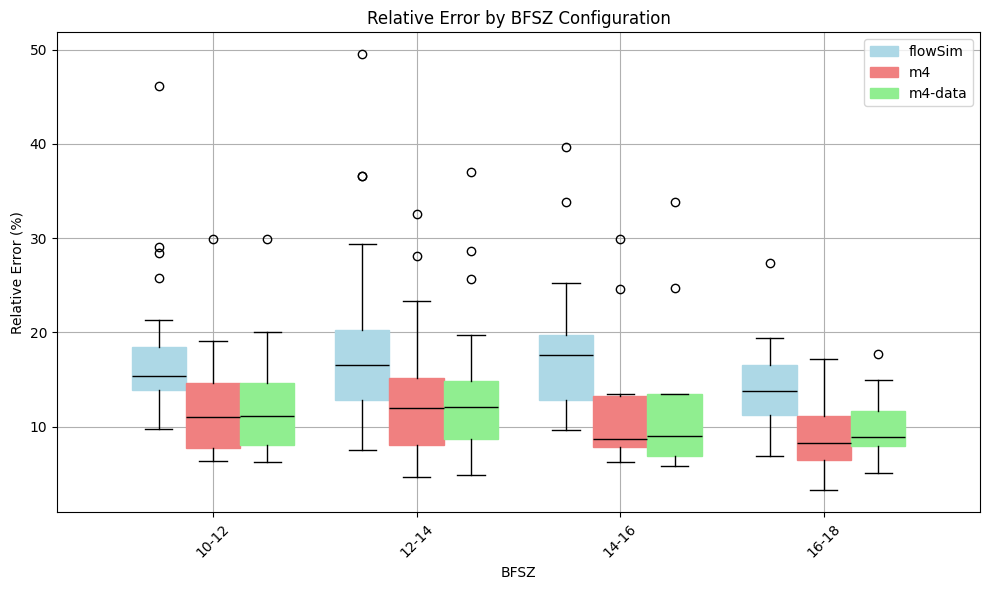

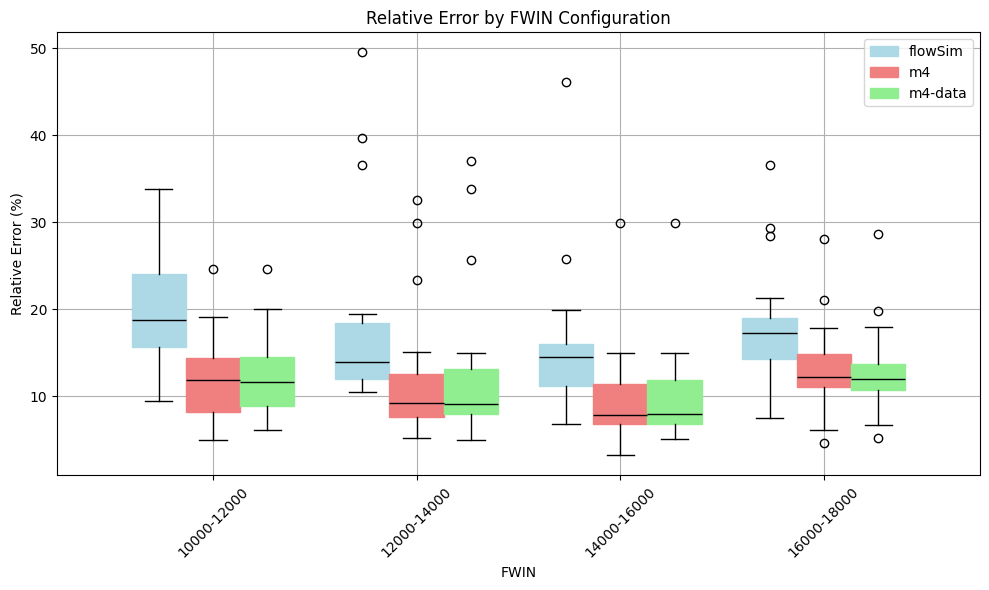

In [3]:
n_scenario=81
empirical_str = "eval_test_new_large"
# legend_list=['flowSim','m4-data','m4-7']
# model_instance_list=['flowsim','topo_remainsize_large_data_7','topo_featrate_7']
legend_list=['flowSim','m4','m4-data']
model_instance_list=['flowsim','topo_featrate_7','topo_remainsize_large_data_7']

                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    # if size_dist!='webserver-all':
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=0,
)

plot_cdf(
    error_list_p99,
    None,
    legend_list,
    x_label="Per-scenario p99 relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=1,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim_large0-sldn: (20000,)
topo_remainsize_large_data_7_large0-sldn: (20000,)
p99 error:[61.96231074970798, 49.58692449266984]
mean error:[15.286766242425397, 7.735132933426757]
median error:[7.548651649241737, 4.051744814148892]


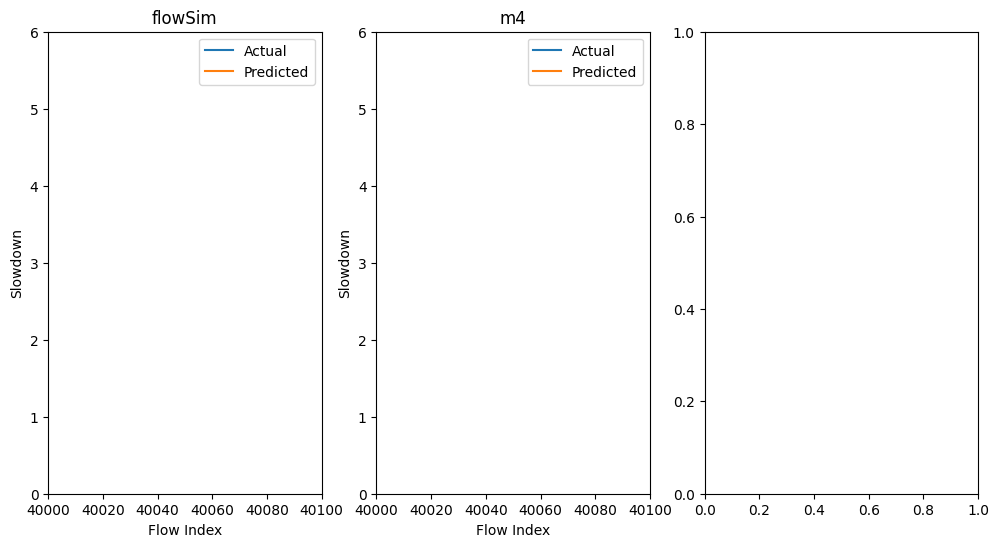

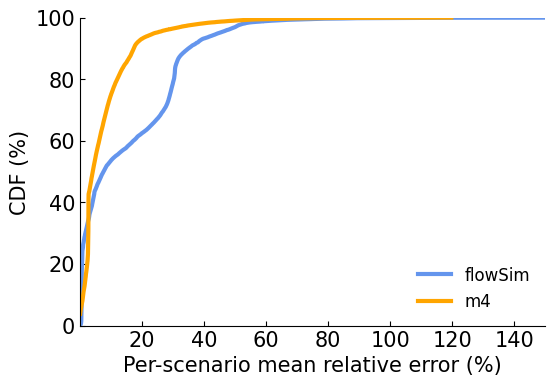

In [5]:
empirical_str = ""
scenario_str="_large0"
# scenario_str=""
# legend_list=['flowSim','m4-flowsim-input','m4-final']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_512_flowsim_input_dropout_19{scenario_str}',f'topo_reprod_19{scenario_str}']
legend_list=['flowSim','m4']
model_instance_list=[f'flowsim{scenario_str}', f'topo_remainsize_large_data_7{scenario_str}']
                     
error_list=[]
sldn_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :20000, 0].squeeze()
    actual_sldns = sldn[:,:20000, 1].squeeze()
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    # relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_list.append([actual_sldns[:],predicted_sldns[:]])
    error_list.append(relative_error_sldn)
error_list=np.array(error_list)
sldn_list=np.array(sldn_list)
print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot each method in a subfigure
for i, (actual, predicted) in enumerate(sldn_list):
    axes[i].plot(actual, label="Actual")
    axes[i].plot(predicted, label="Predicted")
    axes[i].set_title(legend_list[i])
    axes[i].set_xlabel("Flow Index")
    axes[i].set_ylabel("Slowdown")
    axes[i].legend()
    axes[i].set_xlim(40000, 40100)
    axes[i].set_ylim(0, 6)
plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=200,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

index_list: 40
index: 0
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[18.333219093378293, 21.558030576079418]
error_list:[28.124817551465544, 31.315321205909672]
index: 1
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[4.603268699986103, 4.572044057563023]
error_list:[10.499338969445033, 13.531733950018015]
index: 2
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[12.448896867725121, 15.069603905028776]
error_list:[22.373934546867023, 26.346632201039732]
index: 3
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[14.007599325731665, 12.306002182141022]
error_list:[24.792920772947383, 21.949681024958497]
index: 4
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[6.143022208253493, 5.659425944142789]
error_list:[14.778034678004444, 13.507947775605667]
index: 5
flowsim-sldn: (100, 10000, 2)
topo_256_small-sldn: (100, 10000, 2)
error_list:[1

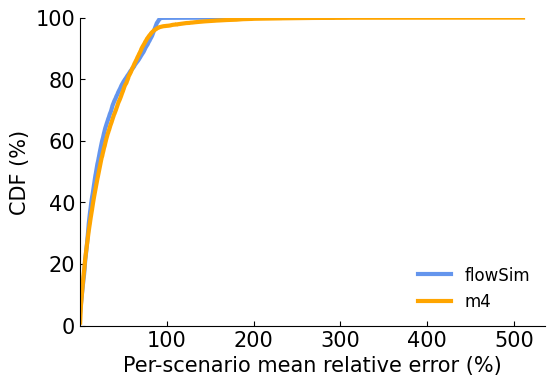

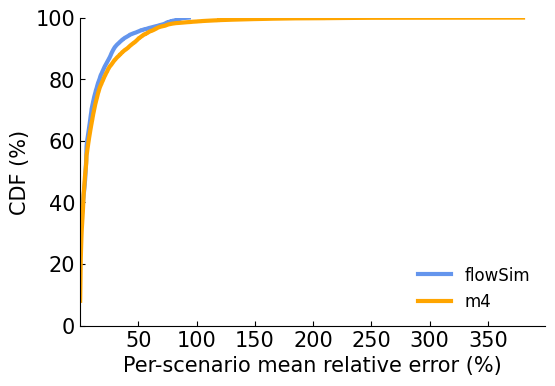

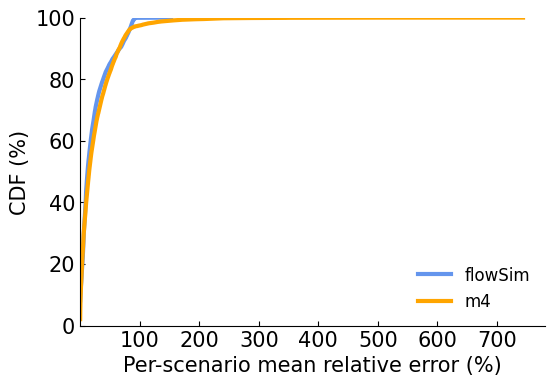

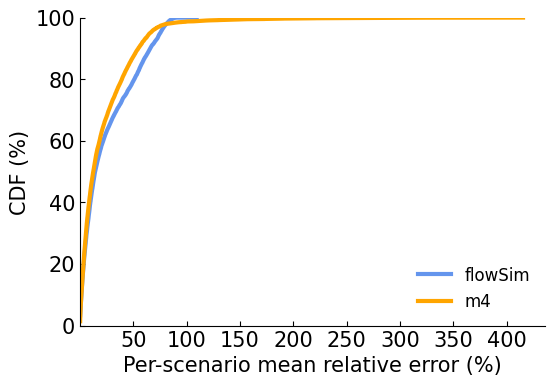

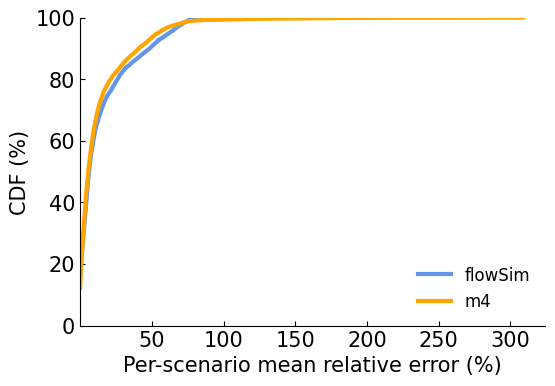

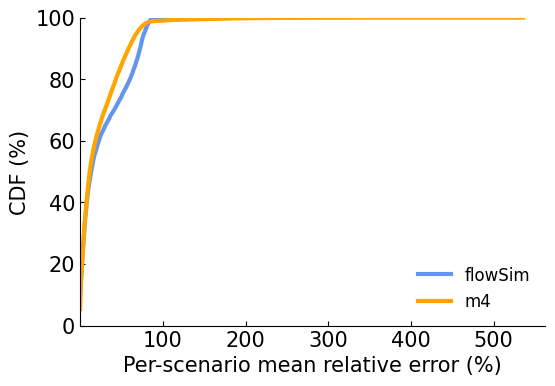

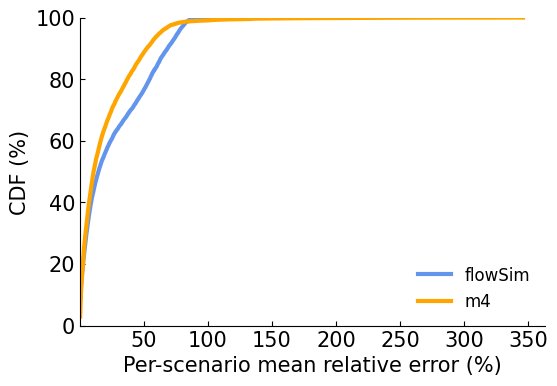

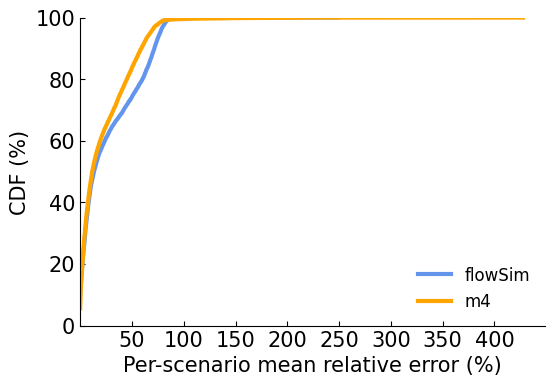

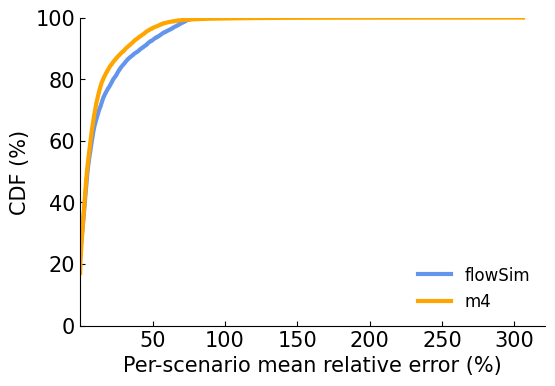

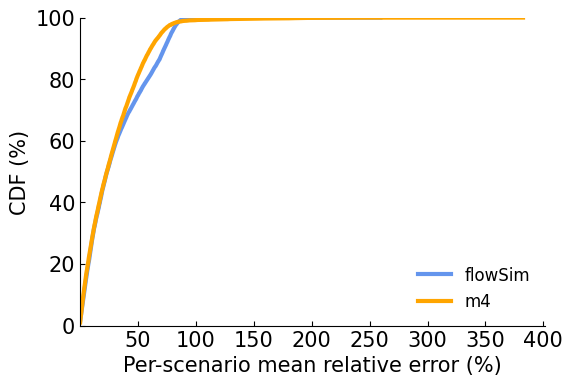

In [32]:
n_scenario=100
# empirical_str = ""
empirical_str = "_empirical"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','btopo_512_flowsim_input']
config_file='/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp_empirical.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/{i}/ns3/fid_topology_flows_dctcp.npy'):
        index_list_ori.append(i)
index_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]['spatial'].split('/')[-1]
    # config=configs[i]['size_dist'].split('/')[-1]
    # config=configs[i]['cluster'].split('/')[-1]
    if config=="cluster_a_2_4.json":
    # if config=="cachefollower-all.txt":
    # if config=="cluster_1_to_1_m4.json":
        index_list.append(idx)
print(f"index_list: {len(index_list)}")


for index in np.arange(10):
# for index in np.arange(1):
    print(f"index: {index}")
    error_list=[]
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        print(f"{model_instance}-sldn: {sldn.shape}")
        predicted_sldns = sldn[index, :, 0]
        actual_sldns=sldn[index, :, 1]
        # predicted_sldns = sldn[:, :, 0]
        # actual_sldns = sldn[:, :, 1]
        # predicted_sldns = sldn[index_list, :, 0]
        # actual_sldns = sldn[index_list, :, 1]
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        # print(f"predicted_sldns: {predicted_sldns}")
        # print(f"actual_sldns: {actual_sldns}")
        # calculate the relative error
        # relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        error_list.append(relative_error_sldn)
    # error_list=np.array(error_list)
    # size_list=np.array(size_list).squeeze()
    # print(f"error_list: {error_list.shape}")
    # print(f"error_list:{[np.mean(x) for x in error_list]}")
    print(f"error_list:{[np.median(x) for x in error_list]}")
    print(f"error_list:{[np.mean(x) for x in error_list]}")

    plot_cdf(
        error_list,
        None,
        legend_list,
        x_label="Per-scenario mean relative error (%)",
        log_switch=False,
        rotate_xaxis=False,
        # ylim_low=90,
        # xlim=150,
        xlim_bottom=0.01,
        fontsize=15,
        legend_font=12,
        loc=4,
        enable_abs=True,
        group_size=5,
        fig_idx=index
    )
    continue
    print(f"size_list: {size_list.shape}")
    fsize_total_per_flow=np.digitize(size_list.flatten(), balance_size_bins)
    print(f"fsize_total_per_flow: {fsize_total_per_flow.shape}")
    error_list=np.reshape(error_list, [error_list.shape[0], -1])
    x=[]
    for k in range(len(balance_size_bins_label)):
        target_idx=fsize_total_per_flow==k
        tmp=error_list[:, target_idx]  
        x.append([np.mean(tmp, axis=1), np.max(tmp, axis=1)])
        x=np.array(x)
        print(f"x: {x.shape}")

    plot_res=x[:,0,:].squeeze().T
    print(f"plot_res: {plot_res.shape}")
    plt.figure(fig_index,figsize=(5, 3))
    plt.title(f"per-flow mean error on {dataset_str[1:]} set", fontsize="x-large")
    for i in range(len(plot_res)):
        plt.plot(plot_res[i], label=legend_list[i])
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=30)
        plt.legend(loc="lower left")

    plt.xlabel("Flow size")
    plt.ylabel(f"relative error of per-flow sldn (%)")
    plt.axvline(x=6, color='r', linestyle='--')
    plt.axvline(x=7, color='b', linestyle='--')
    # plt.axhline(y=50, color='k', linestyle='--')
    # plt.text(0, 50, '50%', color='k')
    plt.axhline(y=10, color='k', linestyle='--')
    plt.text(0, 10, '10%', color='k')
    plt.yscale('log')
    fig_index+=1

    plot_res=x[:,1,:].squeeze().T
    print(f"plot_res: {plot_res.shape}")
    plt.figure(fig_index,figsize=(5, 3))
    plt.title(f"per-flow p99 error on {dataset_str[1:]} set", fontsize="x-large")
    for i in range(len(plot_res)):
        plt.plot(plot_res[i], label=legend_list[i])
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=30)
        plt.legend()

    plt.xlabel("Flow size")
    plt.ylabel(f"relative error of per-flow sldn (%)")
    plt.axvline(x=6, color='r', linestyle='--')
    plt.axvline(x=7, color='b', linestyle='--')
    plt.axhline(y=50, color='k', linestyle='--')
    plt.text(0, 50, '50%', color='k')
    plt.axhline(y=10, color='k', linestyle='--')
    plt.text(0, 10, '10%', color='k')
    plt.yscale('log')
    fig_index+=1

common_scenarios: {1, 3, 67, 69, 75, 84, 55, 24, 88, 62}
[10, 10, 10]
[0.08761208057403565, 84.31884124279023, 83.89564723968506]


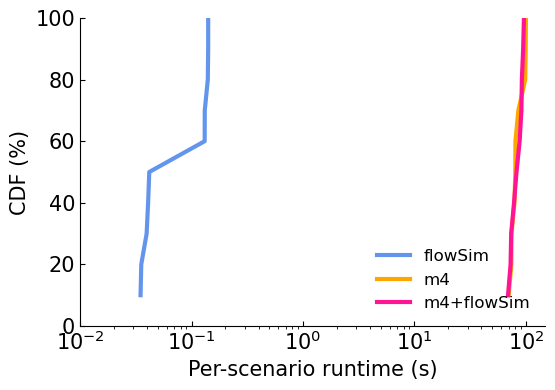

In [6]:
import re

def read_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            log_text = file.read()
        return log_text
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None

def extract_scenario_times(log_text, idx=0):
    # Regex patterns for time elapsed and workload scenario
    time_pattern = r"Time elapsed:\s([\d.]+)"
    workload_pattern = r"Finished workload=(\d+)"

    # Extract times and workload IDs
    elapsed_times = re.findall(time_pattern, log_text)
    workload_ids = re.findall(workload_pattern, log_text)

    # Create a dictionary mapping scenario ID to time elapsed
    scenario_times = {}
    for workload, time in zip(workload_ids, elapsed_times):
        time=float(time)
        if idx==0 or time>1:
            scenario_times[int(workload)] = float(time)
    
    return scenario_times
    
filenmae_list=['flowsim.log', 'link.log', 'link_flowsim.log']
res=[]

for file_idx,log_file_path in enumerate(filenmae_list):
    log_text = read_log_file(log_file_path)
    # Extract time elapsed values
    # print(f"{log_text}")
    elapsed_times = extract_scenario_times(log_text,file_idx)
    res.append(elapsed_times)
# print([np.mean(x) for x in res])

# Find common scenarios between all files
common_scenarios = set(res[0].keys())
for scenario_times in res[1:]:
    common_scenarios.intersection_update(scenario_times.keys())
print(f"common_scenarios: {common_scenarios}")
filtered_res = []
for scenario_times in res:
    filtered_scenario_times = np.array([v for k, v in scenario_times.items() if k in common_scenarios])
    filtered_res.append(filtered_scenario_times)
print([len(x) for x in filtered_res])
print([np.mean(x) for x in filtered_res])
plot_cdf(
    filtered_res,
    None,
    legend_list,
    x_label="Per-scenario runtime (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1